## Table of contents :
* [I - Data-cleaning](#first)
    * [1 - Handling missing values for each dataframe](#first_1)
    * [2 - Merge dataframes](#first_2)
* [II - Overview](#second)
    * [1 - Numerical variable](#second_1)
    * [2 - Categorical variable](#second_2) 
* [III - Feature engineering ](#third)
    * [1 - Sellers](#third_1)
    * [2 - Customers ](#third_2)
    * [3 - Transaction times ](#third_3)
* [ IV - EDA](#fourth)
    * [1 - Univariate analysis](#fourth_1)
        * [1.1 - Quantitative variable](#fourth_1_1)
        * [1.2 - Qualitative variable](#fourth_1_2)
    * [2 - Multivariate analysis](#fourth_2)
    * [3 - Factorial analysis](#fourth_3)
* [ V - RFM segmentation](#fifth)
    * [1 - Preprocessing](#fifth_1)
    * [2 - RFM score](#fifth_2)
    * [3 - RFM segmentation](#fifth_3)
    * [4 - Segment analysis](#fifth_4)
* [ VI - Build modelization subset](#sixth)
    * [1 - Feature overview per dataset](#sixth_1)
    * [2 - Feature engineering](#sixth_2)
    * [3 - Cohort analysis](#sixth_3)
    * [4 - Modelization dataset](#sixth_4)

In [1]:
# Olist module
import sys
sys.path.append("..")
from utils.olist import *

/home/adil/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# I - Data-cleaning <a class="anchor" id="first"></a>

## 1 - Handling missing values for each dataframe <a class="anchor" id="first_1"></a>

### 1.1 - Display NaN count per dataframe

In [2]:
# keywords characterizing the different input files
csv_keywords = ['payments',
                'products',
                'orders',
                'items',
                'sellers',
                'geolocation',
                'customer',
                'reviews']

# Import csv file for each keywords (return a tuple which contains dataframe & csv filename as str)
input_files_by_keywords = {keyword: csv_reader(keyword,
                                               folder_path='../data/csv/',
                                               verbose=False) for keyword in csv_keywords}

# Number of lines of all csv files
total_rows = []

# Print NaN count for each input file
for keyword, input_tuple in input_files_by_keywords.items():
    df, csv_filename = input_tuple
    rows, cols = df.shape
    print('\n')
    file_title = f'- {keyword.capitalize()} : {csv_filename} ({read_int_cleaner(rows)} rows,  {cols} columns) -'
    print('-'*len(file_title))
    print(file_title)
    print('-'*len(file_title))
    display_nan_count_for_each_col(df, margin_size=95)
    total_rows.append(rows)
    
# Only 1/3 csv files contains NaN (concern orders & products files)
# N.B :
# - ideally we could :
#   - train classification models (one for each type of csv file) for the missing qualitative variables
#   - Perform imputations with NMF or linear regression

total_data = 'Total amount of data : '
print('\n')
print('-'*len(total_data))
print(f'{total_data:-<95}   {read_int_cleaner(sum(total_rows))} rows')
print('-'*len(total_data))



--------------------------------------------------------------------------
- Payments : olist_order_payments_dataset.csv (103 886 rows,  5 columns) -
--------------------------------------------------------------------------
order_id--------------------------------------------------------------------------------------- 0  (0.0%)
payment_sequential----------------------------------------------------------------------------- 0  (0.0%)
payment_type----------------------------------------------------------------------------------- 0  (0.0%)
payment_installments--------------------------------------------------------------------------- 0  (0.0%)
payment_value---------------------------------------------------------------------------------- 0  (0.0%)


-------------------------------------------------------------------
- Products : olist_products_dataset.csv (32 951 rows,  9 columns) -
-------------------------------------------------------------------
product_id---------------------------

In [3]:
# Overview reviews csv file 
input_files_by_keywords['reviews'][0].head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [4]:
# Delete variables which have over-represented NaN values
delete_cols(input_files_by_keywords['reviews'][0], ['review_comment_title',
                                                    'review_comment_message'])

### 1.2 - Drop NaN for each dataframe

In [5]:
input_files_with_NaN_keywords = ['products', 'orders'] # reviews

# Rebuild input files by keywords dictionary (drop NaN from products & orders dataframes)
input_files_by_keywords_cleaned = {}

for keyword, input_tuple in input_files_by_keywords.items():
    df, _ = input_tuple
    if keyword in input_files_with_NaN_keywords:
        input_files_by_keywords_cleaned[keyword] = df.dropna()
    else:
        input_files_by_keywords_cleaned[keyword] = df

total_rows_cleaned = []
# Check NaN dropped 
for keyword in input_files_with_NaN_keywords:
    keyword_title = f'- {keyword.capitalize()} -'
    print('-'*len(keyword_title))
    print(keyword_title)
    print('-'*len(keyword_title))
    display_nan_count_for_each_col(input_files_by_keywords_cleaned[keyword], margin_size=95)
    print('-'*len(keyword_title))
    get_data_loss(input_files_by_keywords_cleaned[keyword], input_files_by_keywords[keyword][0])
    print('\n')
    total_rows_cleaned.append(input_files_by_keywords_cleaned[keyword].shape[0])
    
total_data_cleaned = 'Total amount of data (cleaned) : '
total_rows_cleaned = sum(total_rows_cleaned)
total_rows_cleaned += sum([input_tuple[0].shape[0] for keyword, input_tuple in input_files_by_keywords.items() 
                           if keyword not in input_files_with_NaN_keywords])

reduction_ratio = percentage_change(sum(total_rows), total_rows_cleaned, precision=0)

print('\n')
print('-'*len(total_data_cleaned))
print(f'{total_data_cleaned:-<85}   {read_int_cleaner(total_rows_cleaned)} rows ({reduction_ratio} %)')
print('-'*len(total_data_cleaned))

------------
- Products -
------------
product_id------------------------------------------------------------------------------------- 0  (0.0%)
product_category_name-------------------------------------------------------------------------- 0  (0.0%)
product_name_lenght---------------------------------------------------------------------------- 0  (0.0%)
product_description_lenght--------------------------------------------------------------------- 0  (0.0%)
product_photos_qty----------------------------------------------------------------------------- 0  (0.0%)
product_weight_g------------------------------------------------------------------------------- 0  (0.0%)
product_length_cm------------------------------------------------------------------------------ 0  (0.0%)
product_height_cm------------------------------------------------------------------------------ 0  (0.0%)
product_width_cm------------------------------------------------------------------------------- 0  (0.0%)
-------

#### Comment :
- The total amount of data has been **reduced by about 6%**

## 2 - Merge dataframes <a class="anchor" id="first_2"></a>

### Data Schema :
- **5 FK :**
    - **order_id**
    - **product_id**
    - **seller_id**
    - **customer_id**
    - **zip_code_prefix**

<img src="https://i.imgur.com/HRhd2Y0.png" width="700" height="600" align="left">

#### Method : 

Sequential (additive method by keys list) vs divide and conquer (define 2 groups then merge them).

Divide and conquer method chosen.

**Build 2 types of merged dataframes :**
- **sellers_merged** which merge by left join :
    - **olist_sellers_dataset**
    - **olist_items_dataset**
    - **olist_products_dataset**
    - **olist_geolocation_dataset**
    
    
- **customer_merged** which merge by left join :
    - **olist_customer_dataset**
    - **olist_orders_dataset**
    - **olist_payments_dataset**
    - **olist_order_reviews_dataset**
    - **olist_geolocation_dataset**

### 2.1 - Sellers

In [6]:
sellers_df_to_merge = ['sellers',
                       'items',
                       'products',
                       'geolocation']

df_sellers, df_items, df_products, df_geolocation = [input_files_by_keywords_cleaned[keyword] 
                                                     for keyword in sellers_df_to_merge]

In [7]:
df_sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [8]:
df_sellers.rename(columns={'seller_zip_code_prefix': 'geolocation_zip_code_prefix'},
                  inplace=True)

In [9]:
dfs_sellers = [df_items,
               df_products,
               df_geolocation]

sellers_keys = ['seller_id',
                'product_id',
                'geolocation_zip_code_prefix']

sellers_join_types = ['inner' for i in range(len(dfs_sellers))]

sellers_left_suffix = '_sellers'

# First part of working dataframe (sellers part)
df_sellers_part = iterative_merge(df_sellers,
                                  dfs_sellers,
                                  sellers_keys,
                                  sellers_join_types,
                                  sellers_left_suffix)

# Delete redundant columns (keep order_id key in order to merge sellers and customer merged dataframes)
delete_cols(df_sellers_part, ['geolocation_zip_code_prefix',
                              'geolocation_zip_code_prefix_sellers',
                              'geolocation_state',
                              'geolocation_city'])

Dataframe rows inchanged (112650 -> 112650)
Dataframe rows reduced by 1.4 % (112650 -> 111046)
Dataframe rows inchanged (111046 -> 111046)


In [10]:
# Check duplicates
df_sellers_part.drop_duplicates(inplace=True)
df_sellers_part.shape

(111046, 19)

In [11]:
# Check NaN
display_nan_count_for_each_col(df_sellers_part)

seller_id------------------------------------------------------------------------------------------- 0  (0.0%)
seller_city----------------------------------------------------------------------------------------- 0  (0.0%)
seller_state---------------------------------------------------------------------------------------- 0  (0.0%)
order_id-------------------------------------------------------------------------------------------- 0  (0.0%)
order_item_id--------------------------------------------------------------------------------------- 0  (0.0%)
product_id------------------------------------------------------------------------------------------ 0  (0.0%)
shipping_limit_date--------------------------------------------------------------------------------- 0  (0.0%)
price----------------------------------------------------------------------------------------------- 0  (0.0%)
freight_value--------------------------------------------------------------------------------------- 0  (0.0%)
p

In [12]:
df_sellers_part.iloc[:, :10].head(5)

,seller_id,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.2,9.56,esporte_lazer
1,3442f8959a84dea7ee197c632cb2df15,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.7,15.92,esporte_lazer
2,3442f8959a84dea7ee197c632cb2df15,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.8,2.42,esporte_lazer
4039,e0eabded302882513ced4ea3eb0c7059,campinas,SP,d8159fecf6cf88c5f33174f70c304037,1,90d11936871062d5cb6d23175734ea91,2018-06-11 20:30:45,40.0,7.39,consoles_games
68748,e0eabded302882513ced4ea3eb0c7059,campinas,SP,02f4dd90ba0feb8ec394cac05862d2b5,1,f3c62fde9d2e2acf6c7c46648571c070,2018-06-06 16:15:29,79.9,51.06,consoles_games


In [13]:
df_sellers_part.iloc[:, 10:].head(5)

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng
0,26.0,417.0,3.0,700.0,43.0,15.0,35.0,-23.575981,-46.687536
1,27.0,485.0,2.0,600.0,35.0,15.0,28.0,-23.575981,-46.687536
2,44.0,1089.0,1.0,300.0,16.0,5.0,15.0,-23.575981,-46.687536
4039,45.0,677.0,1.0,283.0,20.0,10.0,16.0,-23.575981,-46.687536
68748,19.0,642.0,1.0,150.0,18.0,20.0,11.0,-23.575981,-46.687536


In [14]:
sellers_cols_to_display = ['seller_city',
                           'seller_state',
                           'product_category_name']

# Display unique values for each selected columns
display_unique_values_for_each_col(df_sellers_part,
                                   sellers_cols_to_display,
                                   margin_size=50,
                                   display_type='ct')

seller_city--------------------------------------- 604
seller_state-------------------------------------- 23
product_category_name----------------------------- 73


### 2.2 - Customer

In [15]:
customer_df_to_merge = ['customer',
                        'orders',
                        'payments',
                        'reviews']

df_customer, df_orders, df_payments, df_reviews = [input_files_by_keywords_cleaned[keyword] 
                                                   for keyword in customer_df_to_merge]

In [16]:
# dco = df_customer.merge(df_orders, how='left', left_on='customer_unique_id', right_on='customer_id')
# # Convert datetime as date
# ord_gp = do.groupby('customer_id')['order_purchase_timestamp'].apply(list).reset_index(name='date')
# ord_gp['date'] = ord_gp['date'].map(lambda l: [pd.to_datetime(x).date() for x in l])
# # Get date count for each customer
# ord_gp['date_count'] = ord_gp['date'].map(len)
# # Get unique date count for each customer
# ord_gp['unique_date_count'] = ord_gp['date'].map(set).map(len)
# # ord_gp = ord_gp[ord_gp['date_count'] > 1]
# ord_gp.head()

In [17]:
df_customer.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [18]:
df_customer.rename(columns={'customer_zip_code_prefix': 'geolocation_zip_code_prefix'},
                   inplace=True)

In [19]:
dfs_customers = [df_orders,
                 df_payments,
                 df_reviews,
                 df_geolocation]

customers_keys = ['customer_id',
                  'order_id',
                  'order_id',
                  'geolocation_zip_code_prefix']

customers_join_types = ['inner' for i in range(len(dfs_customers))]

customers_left_suffix = '_cust'

# Second part of working dataframe (customers part)
df_customers_part = iterative_merge(df_customer,
                                    dfs_customers,
                                    customers_keys,
                                    customers_join_types,
                                    customers_left_suffix)

# Delete redundant columns (keep order_id key in order to merge sellers and customer merged dataframes)
delete_cols(df_customers_part, [#'review_id',
                                 'geolocation_zip_code_prefix',
                                 'geolocation_zip_code_prefix_cust',
                                 'geolocation_state',
                                 'geolocation_city'])

Dataframe rows inchanged (96461 -> 96461)
Dataframe rows increased by 4.4 % (96461 -> 100739)
Dataframe rows increased by 0.6 % (100739 -> 101316)
Dataframe rows inchanged (101316 -> 101316)


In [20]:
# Check duplicates
df_customers_part.drop_duplicates(inplace=True)
df_customers_part.shape

(101316, 21)

In [21]:
# Check NaN
display_nan_count_for_each_col(df_customers_part)

customer_id----------------------------------------------------------------------------------------- 0  (0.0%)
customer_unique_id---------------------------------------------------------------------------------- 0  (0.0%)
customer_city--------------------------------------------------------------------------------------- 0  (0.0%)
customer_state-------------------------------------------------------------------------------------- 0  (0.0%)
order_id-------------------------------------------------------------------------------------------- 0  (0.0%)
order_status---------------------------------------------------------------------------------------- 0  (0.0%)
order_purchase_timestamp---------------------------------------------------------------------------- 0  (0.0%)
order_approved_at----------------------------------------------------------------------------------- 0  (0.0%)
order_delivered_carrier_date------------------------------------------------------------------------ 0  (0.0%)
o

In [22]:
df_customers_part.head(2)

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,...,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26 00:00:00,2017-05-30 22:34:40,-23.560771,-46.65925
651,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,franca,SP,95261f608a64bbbe760a212b4d48a4ee,delivered,2018-06-15 20:07:13,2018-06-15 20:41:11,2018-06-18 15:52:00,2018-06-21 12:18:32,...,1,credit_card,8,94.77,16a27e5ffd29a7cdf0e4984b0cab46b7,5,2018-06-22 00:00:00,2018-06-26 19:17:40,-23.560771,-46.65925


In [23]:
customers_cols_to_display = ['customer_city',
                             'customer_state',
                             'order_status',
                             'payment_sequential',
                             'payment_type',
                             'payment_installments']

# Display unique values for each selected columns
display_unique_values_for_each_col(df_customers_part,
                                   customers_cols_to_display,
                                   margin_size=50,
                                   display_type='ct')

customer_city------------------------------------- 4085
customer_state------------------------------------ 27
order_status-------------------------------------- 2
payment_sequential-------------------------------- 26
payment_type-------------------------------------- 4
payment_installments------------------------------ 24


In [24]:
# Main PK is customer_unique_id 
# (see : https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv)
print(len(df_customers_part.customer_id.unique()))
print(len(df_customers_part.customer_unique_id.unique()))
df_customers_part.head(2)

96460
93341


,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,...,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26 00:00:00,2017-05-30 22:34:40,-23.560771,-46.65925
651,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,franca,SP,95261f608a64bbbe760a212b4d48a4ee,delivered,2018-06-15 20:07:13,2018-06-15 20:41:11,2018-06-18 15:52:00,2018-06-21 12:18:32,...,1,credit_card,8,94.77,16a27e5ffd29a7cdf0e4984b0cab46b7,5,2018-06-22 00:00:00,2018-06-26 19:17:40,-23.560771,-46.65925


### 2.3 - Merge by order_id

In [25]:
df = df_customers_part.merge(df_sellers_part,
                             on='order_id',
                             how='inner',
                             suffixes=('_customers', '_sellers'))

df.rename(columns={'order_item_id': 'order_item_qty'}, inplace=True)

delete_cols(df, 'customer_id')

df.rename(columns={'customer_unique_id': 'customer_id'}, inplace=True)

df.shape

(114073, 38)

In [26]:
# Check duplicates
df.drop_duplicates(subset=['customer_id',
                           'order_id',
                           'payment_value',
                           'order_purchase_timestamp'], inplace=True)
df.shape

(98773, 38)

In [27]:
display_nan_count_for_each_col(df)

customer_id----------------------------------------------------------------------------------------- 0  (0.0%)
customer_city--------------------------------------------------------------------------------------- 0  (0.0%)
customer_state-------------------------------------------------------------------------------------- 0  (0.0%)
order_id-------------------------------------------------------------------------------------------- 0  (0.0%)
order_status---------------------------------------------------------------------------------------- 0  (0.0%)
order_purchase_timestamp---------------------------------------------------------------------------- 0  (0.0%)
order_approved_at----------------------------------------------------------------------------------- 0  (0.0%)
order_delivered_carrier_date------------------------------------------------------------------------ 0  (0.0%)
order_delivered_customer_date----------------------------------------------------------------------- 0  (0.0%)
o

# II - Overview <a class="anchor" id="second"></a>

In [28]:
df.head(2)

,customer_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat_sellers,geolocation_lng_sellers
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,-23.548258,-46.649825
1,2761fee7f378f0a8d7682d8a3fa07ab1,franca,SP,95261f608a64bbbe760a212b4d48a4ee,delivered,2018-06-15 20:07:13,2018-06-15 20:41:11,2018-06-18 15:52:00,2018-06-21 12:18:32,2018-07-05 00:00:00,...,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,-23.576881,-46.695142


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98773 entries, 0 to 114072
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    98773 non-null  object 
 1   customer_city                  98773 non-null  object 
 2   customer_state                 98773 non-null  object 
 3   order_id                       98773 non-null  object 
 4   order_status                   98773 non-null  object 
 5   order_purchase_timestamp       98773 non-null  object 
 6   order_approved_at              98773 non-null  object 
 7   order_delivered_carrier_date   98773 non-null  object 
 8   order_delivered_customer_date  98773 non-null  object 
 9   order_estimated_delivery_date  98773 non-null  object 
 10  payment_sequential             98773 non-null  int64  
 11  payment_type                   98773 non-null  object 
 12  payment_installments           98773 non-null

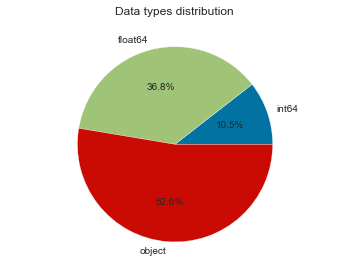

In [30]:
plot_empirical_distribution(df.dtypes, var_type='quali', title='Data types')

## 1 - Numerical variable <a class="anchor" id="second_1"></a>

In [31]:
numerical_cols = df.select_dtypes(include=[float, int]).columns
print(f'Total numerical columns : {df[numerical_cols].shape[1]}')
df[numerical_cols].head(2)

Total numerical columns : 18


,payment_sequential,payment_installments,payment_value,review_score,geolocation_lat_customers,geolocation_lng_customers,order_item_qty,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat_sellers,geolocation_lng_sellers
0,1,2,146.87,4,-23.560771,-46.65925,1,124.99,21.88,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,-23.548258,-46.649825
1,1,8,94.77,5,-23.560771,-46.65925,1,79.90,14.87,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,-23.576881,-46.695142


## 2 - Categorical variable <a class="anchor" id="second_2"></a>

#### 2.1 - All categorical variable

In [32]:
categorical_cols = df.select_dtypes(include=[object]).columns
print(f'Total categorical columns : {df[categorical_cols].shape[1]}')
df[categorical_cols].head(2)

Total categorical columns : 20


,customer_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,review_id,review_creation_date,review_answer_timestamp,seller_id,seller_city,seller_state,product_id,shipping_limit_date,product_category_name
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,credit_card,88b8b52d46df026a9d1ad2136a59b30b,2017-05-26 00:00:00,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,a9516a079e37a9c9c36b9b78b10169e8,2017-05-22 15:22:12,moveis_escritorio
1,2761fee7f378f0a8d7682d8a3fa07ab1,franca,SP,95261f608a64bbbe760a212b4d48a4ee,delivered,2018-06-15 20:07:13,2018-06-15 20:41:11,2018-06-18 15:52:00,2018-06-21 12:18:32,2018-07-05 00:00:00,credit_card,16a27e5ffd29a7cdf0e4984b0cab46b7,2018-06-22 00:00:00,2018-06-26 19:17:40,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,99a4788cb24856965c36a24e339b6058,2018-06-19 20:30:41,cama_mesa_banho


In [33]:
dummy_cols = ['customer_city',
              'customer_state',
              'order_status',
              'payment_type',
              'seller_city',
              'seller_state',
              'product_category_name']

#### 2.2 - Datetime variable

In [34]:
date_cols = [col for col in categorical_cols if col not in dummy_cols and col.endswith('_id') is False]
date_cols

['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'review_creation_date',
 'review_answer_timestamp',
 'shipping_limit_date']

In [35]:
decompose_datetime(df, date_cols, convert_to_datetime=True, autodelete=True)
df.head(2)

,customer_id,customer_city,customer_state,order_id,order_status,payment_sequential,payment_type,payment_installments,payment_value,review_id,...,review_answer_year,review_answer_month,review_answer_day,review_answer_hour,review_answer_ts,shipping_limit_year,shipping_limit_month,shipping_limit_day,shipping_limit_hour,shipping_limit_ts
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,...,2017,5,30,22,1496183680,2017,5,22,15,1495466532
1,2761fee7f378f0a8d7682d8a3fa07ab1,franca,SP,95261f608a64bbbe760a212b4d48a4ee,delivered,1,credit_card,8,94.77,16a27e5ffd29a7cdf0e4984b0cab46b7,...,2018,6,26,19,1530040660,2018,6,19,20,1529440241


#### 2.2.1 - Analysis of the distribution of Datetime variable

In [36]:
df_period = []
for period in ['year', 'month', 'day', 'hour']:
    gp_period = []
    for date_col in date_cols:
        rebuilt_col = "_".join(date_col.split('_')[:-1])
        gp_date_col = df.groupby(f'{rebuilt_col}_{period}')[f'{rebuilt_col}_{period}'].count()
        gp_period.append(gp_date_col)
    df_date_vars_period = pd.concat(gp_period, axis=1).fillna(0).astype(int)
    df_date_vars_period.index.set_names(period.capitalize(), inplace=True)
    df_period.append(df_date_vars_period)

In [37]:
# Year (2016 and 2020 are underrepresented)
df_period[0].T

Year,2016,2017,2018,2020
order_purchase_year,285,44611,53877,0
order_approved_year,285,44556,53932,0
order_delivered_carrier_year,285,44003,54485,0
order_delivered_customer_year,285,42086,56402,0
order_estimated_delivery_year,282,39888,58603,0
review_creation_year,285,42371,56117,0
review_answer_year,272,41709,56792,0
shipping_limit_year,285,43643,54844,1


In [38]:
# Month
df_period[1].T

Month,1,2,3,4,5,6,7,8,9,10,11,12
order_purchase_month,7926,8315,9769,9320,10592,9542,10340,10767,4268,4910,7442,5582
order_approved_month,7816,8292,9856,9125,10797,9544,10183,10952,4286,4872,7299,5751
order_delivered_carrier_month,7660,8095,9924,9215,10889,9582,9928,11558,4197,4855,6748,6122
order_delivered_customer_month,6953,7315,9367,9911,11180,10364,9591,12927,4120,4859,4859,7327
order_estimated_delivery_month,5537,6507,11334,8903,11058,8310,10641,13769,6370,4182,4826,7336
review_creation_month,6387,7418,10048,9292,11260,10236,9219,13423,4150,4611,4841,7888
review_answer_month,6426,7392,9747,9679,11144,9872,9503,13135,4737,4728,4698,7712
shipping_limit_month,7132,8019,9930,8754,11326,9538,9667,12255,4252,4819,6312,6769


In [39]:
# Day
df_period[2]

,order_purchase_day,order_approved_day,order_delivered_carrier_day,order_delivered_customer_day,order_estimated_delivery_day,review_creation_day,review_answer_day,shipping_limit_day
Day,,,,,,,,
1,3118,3190,2240,2265,2836,2983,2779,2764
2,3193,3092,2964,2830,2864,2261,3259,2633
3,3251,3146,3241,3402,3068,2921,2935,2720
4,3441,2953,3307,3093,3235,3287,3051,2899
5,3391,3927,3183,3242,3873,2961,3113,3349
6,3380,3341,3550,3392,3839,3230,3220,2926
7,3354,3577,3534,3224,3182,3386,3241,3467
8,3306,3300,3384,3261,3540,3308,3111,3648
9,3238,3237,3432,3341,3295,3234,2963,3406


In [40]:
# Hour
df_period[3]

,order_purchase_hour,order_approved_hour,order_delivered_carrier_hour,order_delivered_customer_hour,order_estimated_delivery_hour,review_creation_hour,review_answer_hour,shipping_limit_hour
Hour,,,,,,,,
0,2402,2003,2409,2942,98773,98690,6565,2157
1,1160,1522,1347,1532,0,83,5848,1442
2,507,6813,610,670,0,0,3769,6927
3,264,5331,266,260,0,0,2276,5353
4,208,3219,176,195,0,0,1104,3409
5,182,1003,292,201,0,0,544,869
6,480,900,698,282,0,0,402,904
7,1214,1450,1072,400,0,0,423,1365
8,2965,2280,1989,811,0,0,1013,2344


In [41]:
# Clean up (filter & delete)
date_cols_year = ["_".join(col.split('_')[:-1])+'_year' for col in date_cols]
df = df[~df[date_cols_year].isin([2016, 2020]).any(axis=1)]
delete_cols(df, 'order_estimated_delivery_hour')

# III - Feature engineering <a class="anchor" id="third"></a>

## 1 - Sellers <a class="anchor" id="third_1"></a>

#### 1.1 - Variable which concerns the total number of orders per seller

In [42]:
# create variable which concerns the total number of orders per seller
total_orders_per_seller = dict(df.groupby('seller_id')['order_id'].count())
df['seller_total_orders'] = df['seller_id'].map(total_orders_per_seller)

#### 1.2 - Variable which concerns the total number of products sold per seller

In [43]:
# create variable which concerns the total number of products sold per seller
sgp = df.groupby(['seller_id', 'product_id', 'order_item_qty'])['product_id'].count().to_frame()
# N.B : order_item_id is the quantity of items ordered for each order.
# (see : https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv)
# We multiply this quantity by the number of products ordered
sgp['total_products_sold'] = sgp.index.get_level_values('order_item_qty') * sgp['product_id']
total_products_sold_per_seller = dict(sgp.groupby(level=['seller_id'])['total_products_sold'].sum())
df['seller_total_products_sold'] = df['seller_id'].map(total_products_sold_per_seller)

#### 1.3 - Variable which concerns the proportion of products sold in a single quantity compared to the total sold

In [44]:
# 1 => all products sold were purchased in a single quantity
df['seller_uniq_products_sold_ratio'] = np.round(df['seller_total_orders'] / df['seller_total_products_sold'], 2)

#### 1.4 - Variable which normalize freight value for each item sold

In [45]:
# Item freight value item (if an order has more than one item the freight value is splitted between items)
df['freight_value_per_item'] = df['freight_value'] / df['order_item_qty']

#### 1.5 - Variables which count (unique & total) customers per seller

In [46]:
seller_gp_customers = df.groupby('seller_id')['customer_id']
df['seller_uniq_customers_ct'] = df['seller_id'].map(dict(seller_gp_customers.nunique()))
df['seller_total_customers_ct'] = df['seller_id'].map(dict(seller_gp_customers.count()))
df['seller_uniq_customers_ratio'] = np.round(df['seller_uniq_customers_ct'] / df['seller_total_customers_ct'], 2)

#### 1.6 - Variables which count recurring (total & ratio) customers per seller

In [47]:
df['seller_total_recurring_customers_ct'] = df['seller_total_customers_ct'] - df['seller_uniq_customers_ct']
recurr_customers_per_seller_ratio = df['seller_total_recurring_customers_ct'] / df['seller_total_customers_ct']
df['seller_recurring_customers_ratio'] = np.round(recurr_customers_per_seller_ratio, 2)

## 2 - Customers <a class="anchor" id="third_2"></a>

#### 2.1 - Variable which concerns the total number of orders per customer

In [48]:
total_orders_per_customer = dict(df.groupby('customer_id')['order_id'].count())
df['customer_total_orders'] = df['customer_id'].map(total_orders_per_customer)

#### 2.2 - Variable which concerns the total number of products purchased per customer

In [49]:
cgp = df.groupby(['customer_id', 'product_id', 'order_item_qty'])['product_id'].count().to_frame()
# We multiply this quantity by the number of products ordered
cgp['total_products_purchased'] = cgp.index.get_level_values('order_item_qty') * cgp['product_id']
total_products_purchased_per_cust = dict(cgp.groupby(level=['customer_id'])['total_products_purchased'].sum())
df['customer_total_products_purchased'] = df['customer_id'].map(total_products_purchased_per_cust)

#### 2.3 - Variable which concerns the proportion of products purchased in a single quantity compared to the total orders

In [50]:
# 1 => all ordered products were purchased in a single quantity
# 0.90 => 90% of products were sold only once
cust_uniq_products_purchased_ratio = df['customer_total_orders'] / df['customer_total_products_purchased']
df['cust_uniq_products_purchased_ratio'] = np.round(cust_uniq_products_purchased_ratio, 2)

#### 2.4 - Variables which count recurring (total, ratio) products purchased per customer

In [51]:
# First get the list of products purchased by customers
cust_products_gp = df.groupby('customer_id')['product_category_name'].apply(list).reset_index(name='products')
# Build a lambda function which get the total of recurring products purchased by a customer
get_customer_recurring_products_ct = lambda p: 0 if len(p) == 1 else pd.Series(p).duplicated().sum()
# Map lambda function to groupby dataframe
cust_products_gp['cust_recurr_products_ct'] = cust_products_gp['products'].map(get_customer_recurring_products_ct)
# Build dictionary which selects main needed variables from groupby dataframe
cust_recurr_products_gp_ct_dict = dict(cust_products_gp[['customer_id', 'cust_recurr_products_ct']].values)
# Map dictionary to main cleaned dataset
df['customer_recurring_products_purchased_ct'] = df['customer_id'].map(cust_recurr_products_gp_ct_dict)
# Compute recurring products purchased ratio based on the total of products ordered 
# (= not standardized by order item quantity)
cust_recurr_products_ratio = df['customer_recurring_products_purchased_ct'] / df['customer_total_orders']
df['customer_recurring_products_purchased_ratio'] = np.round(cust_recurr_products_ratio, 2)

#### 2.5 - Variable which get the most recurring product purchased by a customer

In [52]:
# Build a lambda function which get the most recurring product purchased by a customer
get_customer_recurring_product = lambda p: 'no_recurring_product' if len(p) == 1 else pd.Series(p).mode()[0]
# Map lambda function to groupby dataframe
cust_products_gp['most_recurr_product'] = cust_products_gp['products'].map(get_customer_recurring_product)
# Build dictionary which selects main needed variables from groupby dataframe
cust_recurr_product_gp_dict = dict(cust_products_gp[['customer_id', 'most_recurr_product']].values)
# Map dictionary to main cleaned dataset
df['most_recurring_product_purchased'] = df['customer_id'].map(cust_recurr_product_gp_dict)

#### 2.6 - Variables which count (unique & total) sellers per customer

In [53]:
customer_gp_sellers = df.groupby('customer_id')['seller_id']
df['customer_uniq_sellers_ct'] = df['customer_id'].map(dict(customer_gp_sellers.nunique()))
df['customer_total_sellers_ct'] = df['customer_id'].map(dict(customer_gp_sellers.count()))
df['customer_uniq_sellers_ratio'] = np.round(df['customer_uniq_sellers_ct'] / df['customer_total_sellers_ct'], 2)

#### 2.7 - Variables which count recurring (total & ratio) sellers per customer

In [54]:
df['customer_total_recurring_sellers_ct'] = df['customer_total_sellers_ct'] - df['customer_uniq_sellers_ct']
recurr_sellers_per_customer_ratio = df['customer_total_recurring_sellers_ct'] / df['customer_total_sellers_ct']
df['customer_recurring_sellers_ratio'] = np.round(recurr_sellers_per_customer_ratio, 2)

#### 2.8 - Variable which build a customer loyalty indicator

In [55]:
cust_loyalty_ind = df['customer_total_recurring_sellers_ct'] / df['customer_uniq_sellers_ct']
df['customer_loyalty_indicator'] = np.round(cust_loyalty_ind, 2)

In [56]:
df.shape

(98487, 90)

#### 2.9 - Variables which concerns :
- the total number of **orders per customer per year, quarter, month**
- the total number of **payments per customer per year, quarter, month**

In [57]:
%%time

# Define time scale
time_scale = ['year', 'quarter', 'month']
baseline_total_var_ct = df.shape[1]
for ts in time_scale:
    initial_total_var_ct = df.shape[1]
    df = decompose_variable_by_time_scale(df, ts)
    end_total_var_ct = df.shape[1]
    total_var_ct = percentage_change(initial_total_var_ct, end_total_var_ct, precision=1)
    print(f'Total variable count increase by {total_var_ct}% {initial_total_var_ct} --> {end_total_var_ct}')

Total variable count increase by 14.4% 90 --> 103
Total variable count increase by 42.7% 103 --> 147
Total variable count increase by 49.0% 147 --> 219
CPU times: user 6min 23s, sys: 13.5 s, total: 6min 37s
Wall time: 6min 38s


In [58]:
total_var_ct = percentage_change(baseline_total_var_ct, df.shape[1], precision=1)
print(f'Total variable count increase by {total_var_ct}% {baseline_total_var_ct} --> {df.shape[1]}')

Total variable count increase by 143.3% 90 --> 219


#### 3 - Variable which define customer distance from Sao Paulo (in km or m)

In [59]:
# https://geocoder.readthedocs.io/api.html#forward-geocoding

sao_paulo_coords = geocoder.osm('Sao Paulo').latlng

customer_coords_cols = ['geolocation_lat_customers', 'geolocation_lng_customers']

df['customer_dist_km'] = df[customer_coords_cols].apply(lambda coords: get_geodesic_dist(coords,
                                                                                         sao_paulo_coords,
                                                                                         unit='km'), axis=1)

In [60]:
len(df['customer_dist_km'].unique())

11583

#### 3.1 - Variable which define customer total payment sequential operations

In [61]:
# Prepare payment sequential data 

# Rappel : a customer may pay an order with more than 1 payment method. If he does so, a sequence 
#          will be created to accommodate all payments.

payment_seq_per_customer = df.groupby(['customer_id', 'order_id'])['payment_sequential'].apply(list)

payment_seq_per_customer = payment_seq_per_customer.reset_index(name='payment_seq_list')

payment_seq_per_customer['total_payment_sequential'] = payment_seq_per_customer['payment_seq_list'].map(len)

# payment_seq_per_customer['total_payment_sequential']

payment_seq_per_customer.set_index('customer_id', inplace=True)

df = df.join(payment_seq_per_customer.loc[:, 'total_payment_sequential'], on='customer_id')
#payment_seq_per_customer_dict = dict(payment_seq_per_customer['total_payment_sequential'])

#df.loc[:, 'total_payment_sequential'] = df.loc[:, 'customer_id'].map(payment_seq_per_customer_dict)

print(df.shape)

# Check duplicates
df.drop_duplicates(subset=['customer_id', 'order_id', 'order_purchase_ts'], inplace=True)

print(df.shape)

(105882, 221)
(94858, 221)


In [62]:
#df.loc[:, 'total_payment_sequential'] = df.loc[:, 'total_payment_sequential'].astype(int)

## 3 - Transaction times <a class="anchor" id="third_3"></a>

#### 3.1 - Variable which concerns order approved delay (in minutes)

In [63]:
order_approved_delay = df['order_approved_ts'] - df['order_purchase_ts'] 
df['order_approved_delay_in_min'] = pd.to_datetime(order_approved_delay, unit='s').dt.minute

#### 3.2 - Variable which concerns order delivered carrier delay (in day)

In [64]:
order_delivered_carrier_delay = df['order_delivered_carrier_ts'] - df['order_purchase_ts'] 
df['order_delivered_carrier_delay_in_day'] = pd.to_datetime(order_delivered_carrier_delay, unit='s').dt.day

#### 3.3 - Variable which concerns order delivered customer delay starting from carrier (in day)

In [65]:
order_delivered_cust_delay_from_carrier = df['order_delivered_customer_ts'] - df['order_delivered_carrier_ts']
df['order_delivered_cust_delay_from_carrier_in_day'] = pd.to_datetime(order_delivered_cust_delay_from_carrier,
                                                                      unit='s').dt.day

#### 3.4 - Variable which concerns order delivered customer delay starting from purchase (in day)

In [66]:
order_delivered_cust_delay_from_purchase = df['order_delivered_customer_ts'] - df['order_purchase_ts'] 
df['order_delivered_cust_delay_from_purchase_in_day'] = pd.to_datetime(order_delivered_cust_delay_from_purchase,
                                                                      unit='s').dt.day

#### 3.5 - Variables which concerns difference between :
- **order delivered customer** and **order estimated delivery delays** (in day)
- **order delivered carrier** and **order shipping limit delays** (in day) 

In [67]:
order_delivered_cust_delay_from_estim = df['order_estimated_delivery_ts'] - df['order_delivered_customer_ts']

# Rappel => shipping_limit_date :
# - Shows the seller shipping limit date for handling the order over to the logistic partner.
# (see : https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv)

order_delivered_carr_delay_from_shipping_lim = df['shipping_limit_ts'] - df['order_delivered_carrier_ts']

#
order_delivered_delay_eval_dict = {'overvalued': lambda v: v if v > 0 else 0,
                                   'undervalued': lambda v: v if v < 0 else 0,
                                   'matched': lambda v: v if v == 0 else 0}
#
for estim_type, estim_function in order_delivered_delay_eval_dict.items():
    cust_label = f'{estim_type}_order_delivered_cust_delay_in_days'
    carr_label = f'{estim_type}_order_delivered_carrier_delay_from_limit_in_day'
    df[cust_label] = pd.to_datetime(order_delivered_cust_delay_from_estim.map(estim_function), unit='s').dt.day
    df[carr_label] = pd.to_datetime(order_delivered_carr_delay_from_shipping_lim.map(estim_function),
                                    unit='s').dt.day

#### 3.6 - Variable that classifies the ability to predict delivery dates

In [68]:
#

df['estimated_delivery_eval'] = order_delivered_cust_delay_from_estim.map(eval_delivery_date)
# To do : transform as indicator (get_dummies)

#### 3.7 - Variable which concerns order shipping limit date reached (binary variable)  

In [69]:
df['shipping_limit_date_reached'] = order_delivered_carr_delay_from_shipping_lim.map(lambda v: 0 if v >=0 else 1)
# df['shipping_limit_date_reached'].head(2)

In [70]:
# Build subset for EDA
eda = df.copy()
id_cols = [col for col in eda.columns if col.endswith('id') and col not in ['customer_id', 'order_id']]
delete_cols(eda, id_cols)

In [71]:
eda.shape

(94858, 230)

#### 3.8 - Variable which translate product category name in english

In [72]:
# Import product category name translation csv file
df_translator = pd.read_csv('../data/csv/product_category_name_translation.csv')
# Get unique product names from translation dataframe
translator_unique_prod_pt = df_translator.product_category_name
# Get unique product names from EDA dataframe
unique_prod_pt = pd.Series(eda.product_category_name.unique())
# Check if unique product names length are equal
len(translator_unique_prod_pt) == len(unique_prod_pt)

False

In [73]:
# Find missing product category names
missing_prod_name_pt = unique_prod_pt[~unique_prod_pt.isin(translator_unique_prod_pt)].values.tolist()
print(missing_prod_name_pt)
# Assign product category to missing product 
missing_prod_name = {'product_category_name': missing_prod_name_pt,
                     'product_category_name_english': ['la_cuisine', 'computers']}
df_translator.append(pd.DataFrame(missing_prod_name), ignore_index=True)

eda['product_category_name_en'] = eda['product_category_name'].map(dict(df_translator.values))

['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer']


# IV - EDA <a class="anchor" id="fourth"></a>

In [74]:
eda.head(2)

,customer_id,customer_city,customer_state,order_id,order_status,payment_sequential,payment_type,payment_installments,payment_value,review_score,...,order_delivered_cust_delay_from_purchase_in_day,overvalued_order_delivered_cust_delay_in_days,overvalued_order_delivered_carrier_delay_from_limit_in_day,undervalued_order_delivered_cust_delay_in_days,undervalued_order_delivered_carrier_delay_from_limit_in_day,matched_order_delivered_cust_delay_in_days,matched_order_delivered_carrier_delay_from_limit_in_day,estimated_delivery_eval,shipping_limit_date_reached,product_category_name_en
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,1,credit_card,2,146.87,4,...,9,11,1,1,31,1,1,overvalued,1,office_furniture
1,2761fee7f378f0a8d7682d8a3fa07ab1,franca,SP,95261f608a64bbbe760a212b4d48a4ee,delivered,1,credit_card,8,94.77,5,...,6,14,2,1,1,1,1,overvalued,0,bed_bath_table


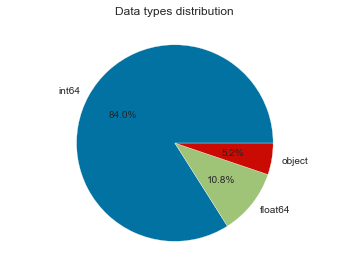

In [75]:
plot_empirical_distribution(eda.dtypes, var_type='quali', title='Data types')

## 1 - Univariate analysis <a class="anchor" id="fourth_1"></a>

### 1.1 - Quantitative variables <a class="anchor" id="fourth_1_1"></a>

### 1.1.1 - Overview

In [76]:
eda[numerical_cols].head(2)

,payment_sequential,payment_installments,payment_value,review_score,geolocation_lat_customers,geolocation_lng_customers,order_item_qty,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat_sellers,geolocation_lng_sellers
0,1,2,146.87,4,-23.560771,-46.65925,1,124.99,21.88,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,-23.548258,-46.649825
1,1,8,94.77,5,-23.560771,-46.65925,1,79.90,14.87,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,-23.576881,-46.695142


### 1.1.2 - Payment validity check

In [77]:
payment_cols = ['price', 'freight_value_per_item'] # payment_value = price + freigh_value
payments_computed = eda['order_item_qty'] * (eda[payment_cols].sum(axis=1))
eda['check_payment_value'] = np.round(payments_computed, 2) == np.round(eda['payment_value'], 2)
# check_payment_cols = ['order_item_qty', 'price', 'freight_value', 'payment_value', 'check_payment_value']
# eda[check_payment_cols][eda['check_payment_value'] == False].head()
wrong_payments = read_int_cleaner(len([v for v in eda['check_payment_value'] if v is False]))
f'{wrong_payments} wrong payments'
# Calculation correction
eda['payment_value'] = np.round(payments_computed, 2)
delete_cols(eda, 'check_payment_value')

In [78]:
eda = eda[eda['payment_value'] > 0]
eda.shape

(94858, 231)

### 1.1.3 - Distributions of quantitative variables 

#### 1.1.3.1 - Histograms

Total numerical variables (lat & lng excluded) : 14


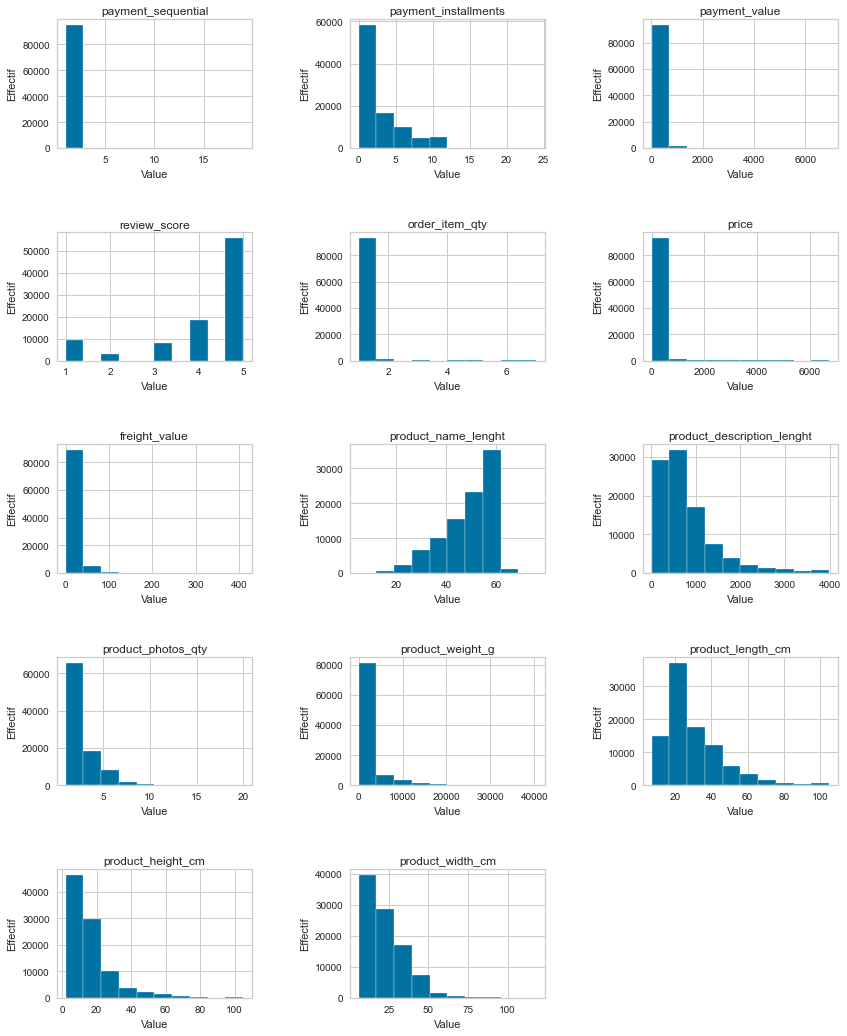

In [79]:
# Plot distribution for each numerical variable

numerical_cols_excluded_geo = [col for col in numerical_cols if 'lat' not in col and 'lng' not in col]
print(f'Total numerical variables (lat & lng excluded) : {len(numerical_cols_excluded_geo)}')

plot_hist_subplots(eda, numerical_cols_excluded_geo, (5, 3))

In [80]:
# 75% of consumers order at least twice
measures_table(eda['customer_total_orders']).T

,count,mean,std,min,25%,50%,75%,max
customer_total_orders,94858.0,1.116216,0.501375,1.0,1.0,1.0,1.0,23.0


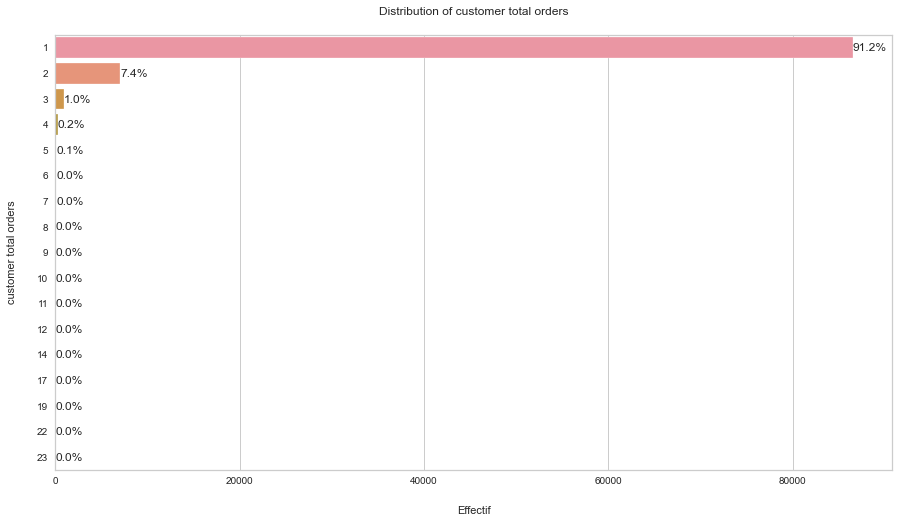

In [81]:
count_plot(eda, 'customer_total_orders')

#### 1.1.3.2 - Metrics table

In [82]:
eda[numerical_cols_excluded_geo].describe().T

,count,mean,std,min,25%,50%,75%,max
payment_sequential,94858.0,1.022307,0.232572,1.00,1.00,1.00,1.00,19.00
payment_installments,94858.0,2.915632,2.709962,0.00,1.00,2.00,4.00,24.00
payment_value,94858.0,146.870962,197.849389,9.09,57.72,96.80,164.17,6929.31
review_score,94858.0,4.144648,1.294221,1.00,4.00,5.00,5.00,5.00
order_item_qty,94858.0,1.017763,0.154800,1.00,1.00,1.00,1.00,7.00
price,94858.0,125.270902,189.705483,0.85,41.80,79.00,139.90,6735.00
freight_value,94858.0,20.182244,15.822049,0.00,13.30,16.39,21.25,409.68
product_name_lenght,94858.0,48.881106,9.972093,5.00,43.00,52.00,57.00,76.00
product_description_lenght,94858.0,793.065635,653.750234,4.00,348.00,606.00,995.00,3992.00
product_photos_qty,94858.0,2.250290,1.745223,1.00,1.00,2.00,3.00,20.00


### 1.1.4 - Selection of quantitative variables constructed from feature engineering by actor 

#### 1.1.4.1 - Sellers

In [83]:
# Sellers quantitative variables (from feature engineering)
sellers_num_cols_built = ['seller_total_orders',
                          'seller_total_products_sold',
                          'seller_uniq_products_sold_ratio',
                          'seller_total_customers_ct',
                          'seller_uniq_customers_ratio',
                          'seller_total_recurring_customers_ct',
                          'seller_recurring_customers_ratio']

print(f'Sellers total numerical variables (from feature engineering) : {len(sellers_num_cols_built)}')

Sellers total numerical variables (from feature engineering) : 7


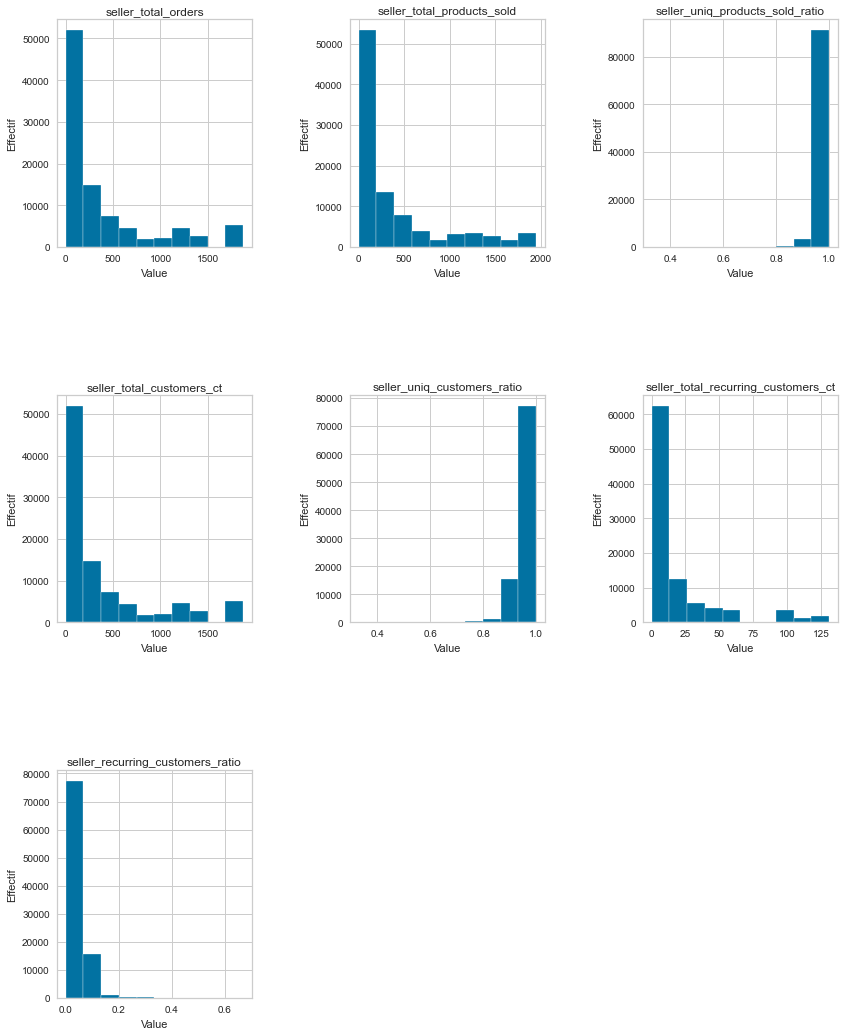

In [84]:
plot_hist_subplots(eda, sellers_num_cols_built, (3, 3))

In [85]:
eda[sellers_num_cols_built].describe().T

,count,mean,std,min,25%,50%,75%,max
seller_total_orders,94858.0,383.279291,499.932857,1.00,53.00,152.00,473.00,1873.00
seller_total_products_sold,94858.0,391.865557,513.476111,1.00,54.00,157.00,486.00,1946.00
seller_uniq_products_sold_ratio,94858.0,0.982998,0.025857,0.33,0.97,0.99,1.00,1.00
seller_total_customers_ct,94858.0,383.279291,499.932857,1.00,53.00,152.00,473.00,1873.00
seller_uniq_customers_ratio,94858.0,0.955821,0.039373,0.33,0.94,0.96,0.98,1.00
seller_total_recurring_customers_ct,94858.0,18.849501,29.106020,0.00,2.00,6.00,21.00,131.00
seller_recurring_customers_ratio,94858.0,0.044179,0.039373,0.00,0.02,0.04,0.06,0.67


#### 1.1.4.2 - Customers

In [86]:
# Customers quantitative variables (from feature engineering)
customers_num_cols_built = ['customer_total_orders',
                            'customer_total_products_purchased',
                            'cust_uniq_products_purchased_ratio',
                            'customer_recurring_products_purchased_ct',
                            'customer_recurring_products_purchased_ratio',
                            'customer_uniq_sellers_ct',
                            'customer_total_sellers_ct',
                            'customer_uniq_sellers_ratio',
                            'customer_total_recurring_sellers_ct',
                            'customer_recurring_sellers_ratio',
                            'customer_loyalty_indicator',
                            'total_customer_payment']

print(f'Customers total numerical variables (from feature engineering) : {len(customers_num_cols_built)}')

Customers total numerical variables (from feature engineering) : 12


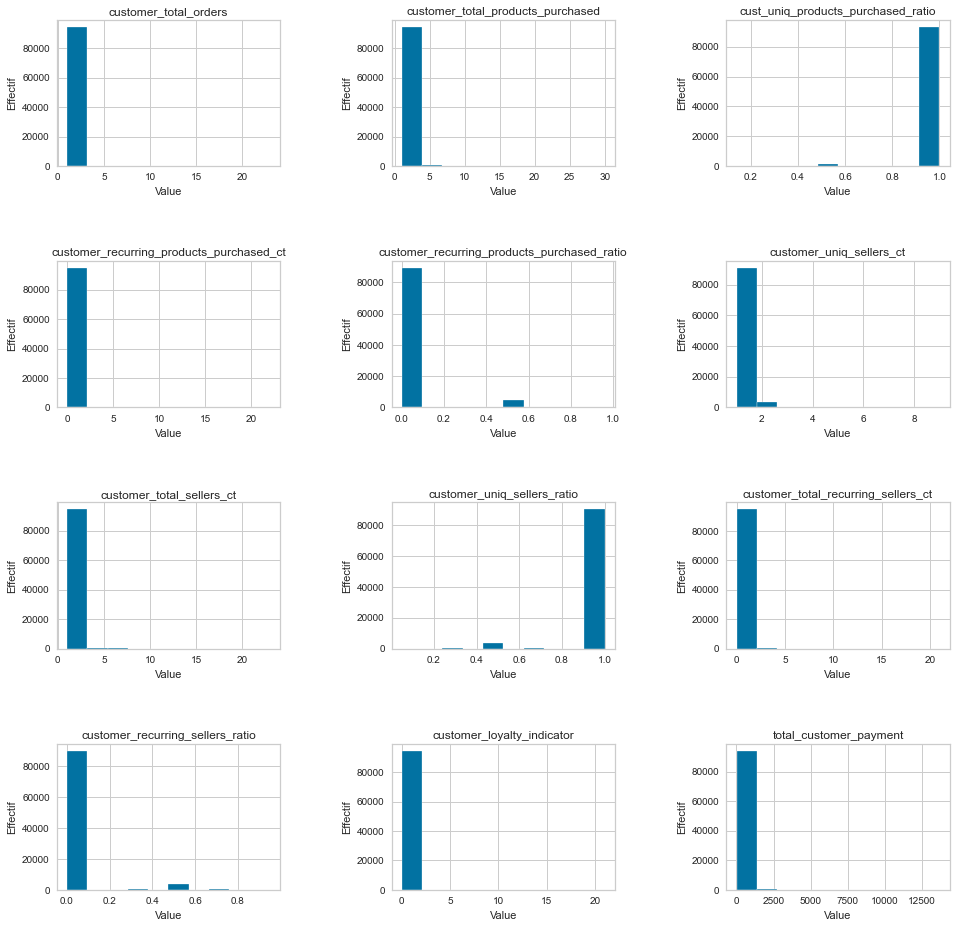

In [87]:
plot_hist_subplots(eda, customers_num_cols_built, (4, 3), fig_size=(16, 16))

In [88]:
eda[customers_num_cols_built].describe().T

,count,mean,std,min,25%,50%,75%,max
customer_total_orders,94858.0,1.116216,0.501375,1.00,1.00,1.00,1.00,23.00
customer_total_products_purchased,94858.0,1.138175,0.566260,1.00,1.00,1.00,1.00,30.00
cust_uniq_products_purchased_ratio,94858.0,0.991579,0.064593,0.14,1.00,1.00,1.00,1.00
customer_recurring_products_purchased_ct,94858.0,0.078475,0.422091,0.00,0.00,0.00,0.00,22.00
customer_recurring_products_purchased_ratio,94858.0,0.030910,0.124321,0.00,0.00,0.00,0.00,0.96
customer_uniq_sellers_ct,94858.0,1.052278,0.282156,1.00,1.00,1.00,1.00,9.00
customer_total_sellers_ct,94858.0,1.116216,0.501375,1.00,1.00,1.00,1.00,23.00
customer_uniq_sellers_ratio,94858.0,0.974857,0.112520,0.05,1.00,1.00,1.00,1.00
customer_total_recurring_sellers_ct,94858.0,0.063938,0.377716,0.00,0.00,0.00,0.00,21.00
customer_recurring_sellers_ratio,94858.0,0.025143,0.112520,0.00,0.00,0.00,0.00,0.95


In [89]:
# After analysis these previous variables (except the last one) seems irrelevant to our current dataset
# delete_cols(eda, [col for col in customers_num_cols_built if col != 'total_customer_payment'])

## 1.2 - Qualitative variables <a class="anchor" id="fourth_1_2"></a>

In [90]:
categorical_cols = [col for col in eda.columns if col not in numerical_cols]
len(categorical_cols)

213

In [91]:
# Selection of the most relevant qualitative variables
categorical_cols_selected = ['customer_city',
                             'customer_state',
                             'seller_city',
                             'seller_state',
                             'product_category_name',                   
                             'payment_type',
                             'payment_installments',
                             'order_status',
                             'order_purchase_month',
                             'order_purchase_day',
                             'order_purchase_hour',
                             'order_delivered_customer_month',
                             'order_delivered_customer_day',
                             'order_delivered_customer_hour',
                             'estimated_delivery_eval',
                             'shipping_limit_date_reached',
                             'most_recurring_product_purchased']

### 1.2.1 - Sellers

#### 1.2.1.1 - Seller State

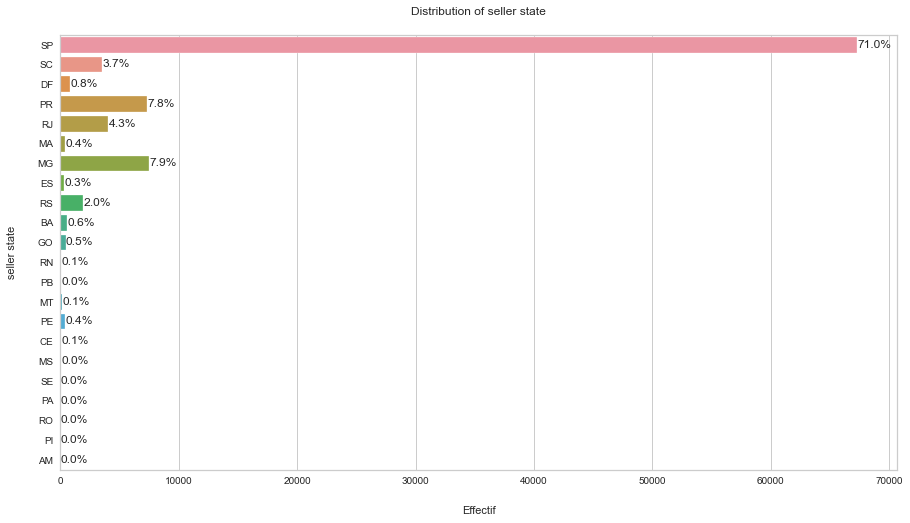

In [92]:
count_plot(eda, 'seller_state')
# São Paulo overrepresented

#### 1.2.1.2 - Seller City

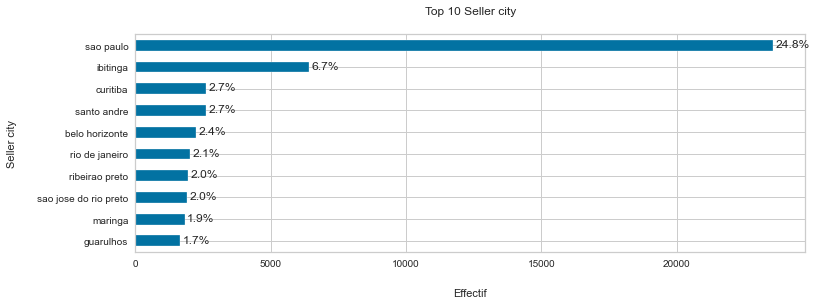

In [93]:
plot_n_top_values(eda, 'seller_city', n=10)

In [94]:
eda.shape

(94858, 231)

### 1.2.2 - Customers

#### 1.2.2.1 - Customer State

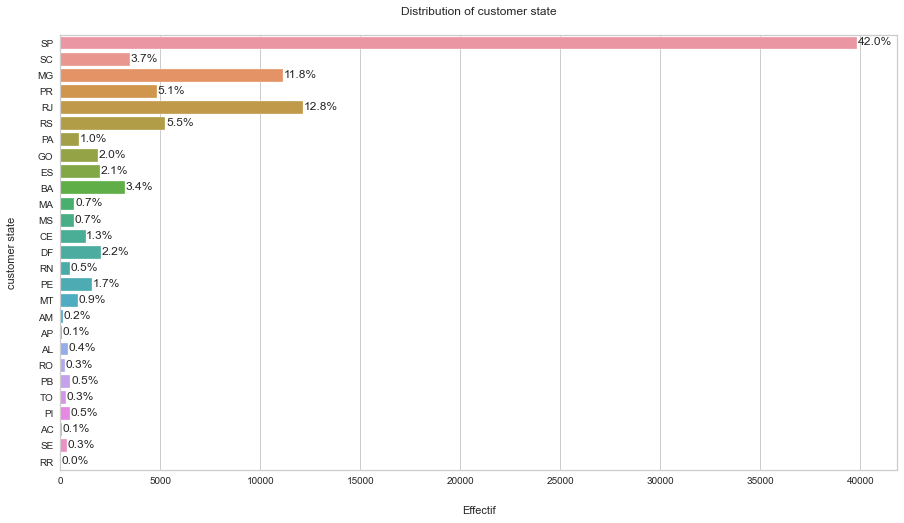

In [95]:
count_plot(eda, 'customer_state')
# São Paulo overrepresented

#### 1.2.2.2 - Customer City

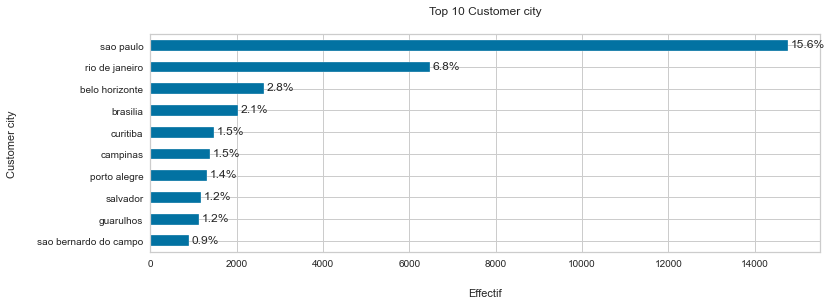

In [96]:
plot_n_top_values(eda, 'customer_city', n=10)

### 1.2.3 - Orders

#### 1.2.3.1 - Payment type

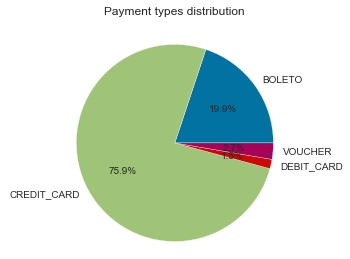

In [97]:
plot_empirical_distribution(eda['payment_type'], var_type='quali', title='Payment types')

#### 1.2.3.2 - Payment sequential

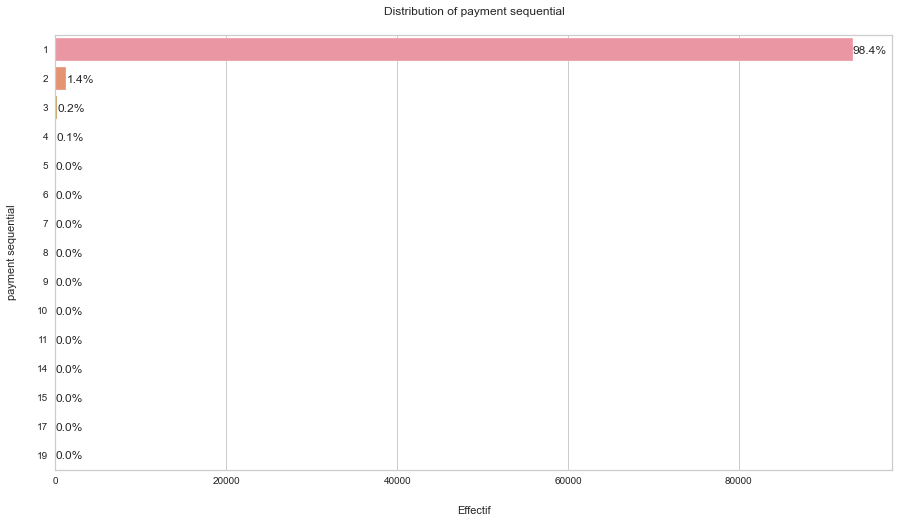

In [98]:
count_plot(eda, 'payment_sequential')

#### 1.2.3.3 - Payment installements

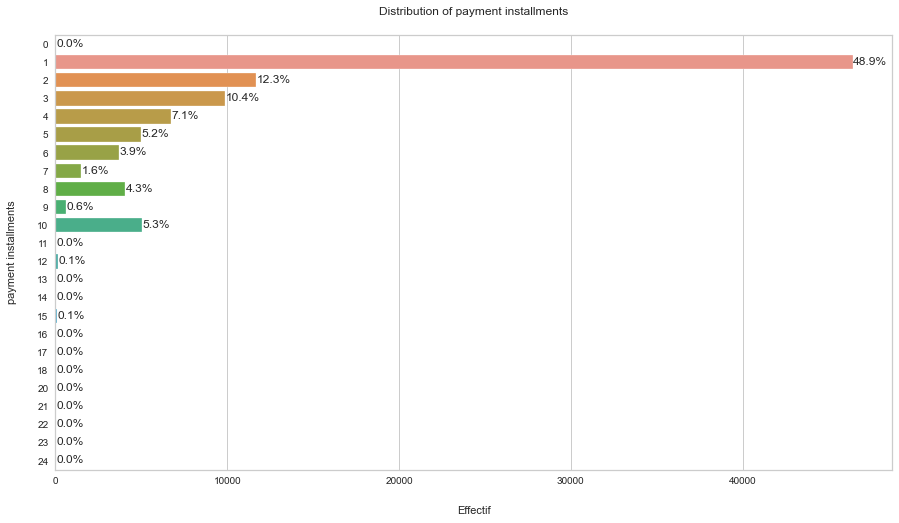

In [99]:
count_plot(eda, 'payment_installments')

#### 1.2.3.4 - Order status

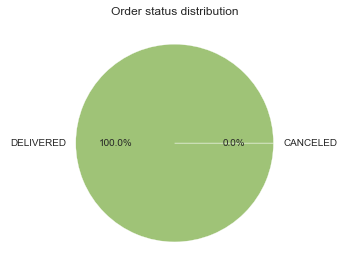

In [100]:
plot_empirical_distribution(eda['order_status'], var_type='quali', title='Order status')

In [101]:
# Get canceled orders count
canceled_orders_count = eda[eda['order_status'] == 'canceled'].shape[0]
print(f'Total canceled orders : {canceled_orders_count}')
# Remove canceled orders
eda = eda[eda['order_status'] != 'canceled']
# Remove order_status variable
delete_cols(eda, 'order_status')

Total canceled orders : 1


#### 1.2.3.5 - Order purchase by period

#### 1.2.3.5.1 - All period (2017 + 2018)

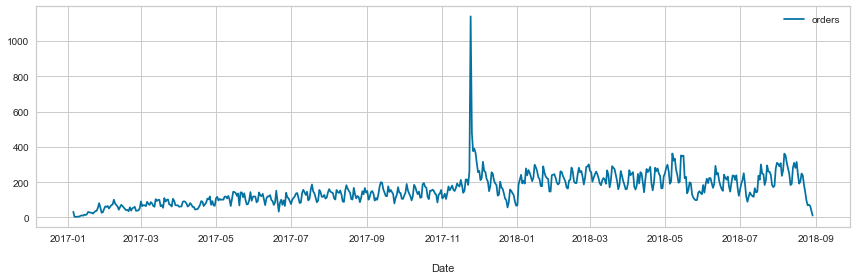

In [102]:
plot_time_serie(eda, 'order_purchase_ts', s=(12, 4))

#### 1.2.3.5.2 - 2017

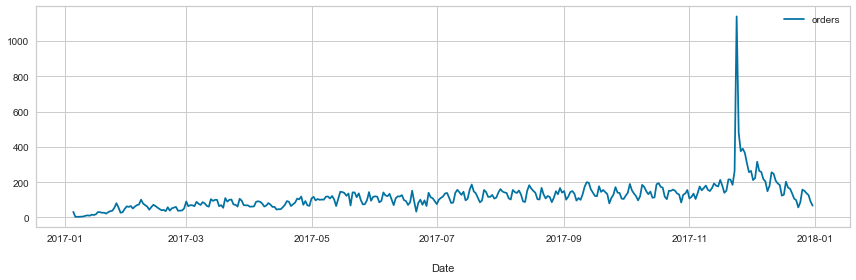

In [103]:
d = plot_time_serie(eda, 'order_purchase_ts', s=(12, 4), time_filter=2017, return_data=True)
# d['order_purchase_date'].unique()

#### 1.2.3.5.3 - 2018

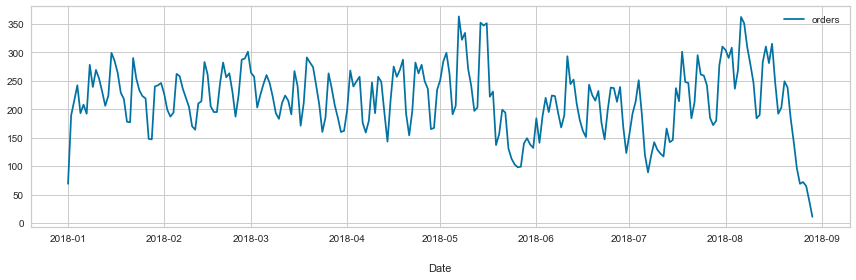

In [104]:
plot_time_serie(eda, 'order_purchase_ts', s=(12, 4), time_filter=2018)

#### 1.2.3.5.4 - Month (all period)

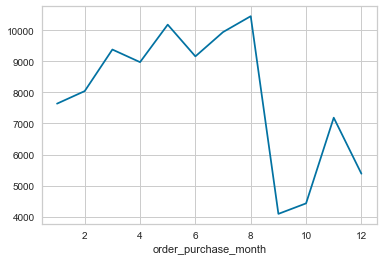

In [105]:
eda.groupby('order_purchase_month')['order_purchase_month'].count().plot()
plt.show()

#### 1.2.3.5.5 - Day (all period)

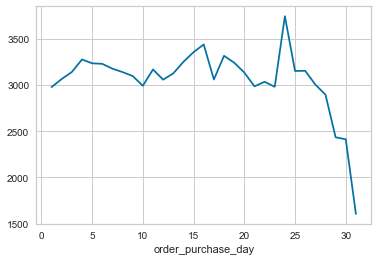

In [106]:
eda.groupby('order_purchase_day')['order_purchase_day'].count().plot()
plt.show()

#### 1.2.3.5.6 - Hour (all period)

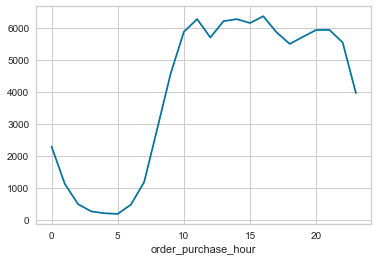

In [107]:
eda.groupby('order_purchase_hour')['order_purchase_hour'].count().plot()
plt.show()

#### 1.2.3.6 - Order delivered by period

#### 1.2.3.6.1 - All period (2017 + 2018)

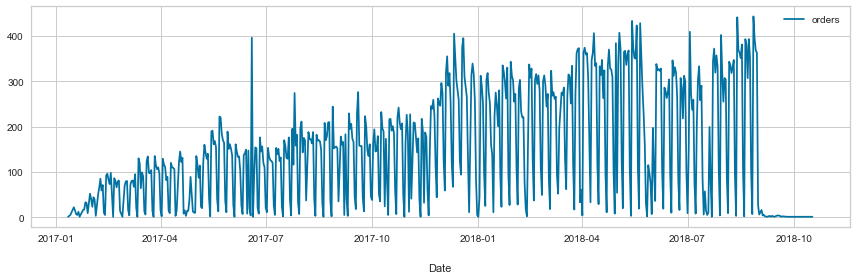

In [108]:
plot_time_serie(eda, 'order_delivered_customer_ts', s=(12, 4))

#### 1.2.3.6.2 - 2017

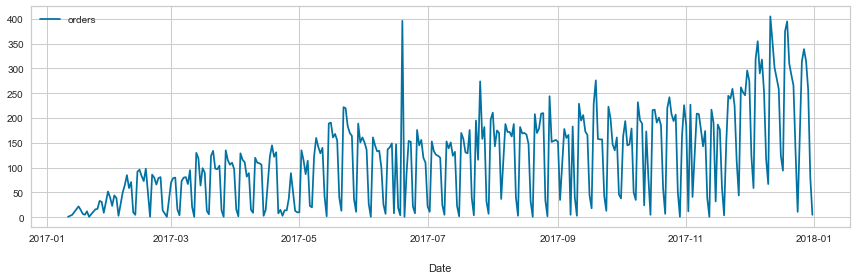

In [109]:
plot_time_serie(eda, 'order_delivered_customer_ts', s=(12, 4), time_filter=2017)

#### 1.2.3.6.3 - 2018

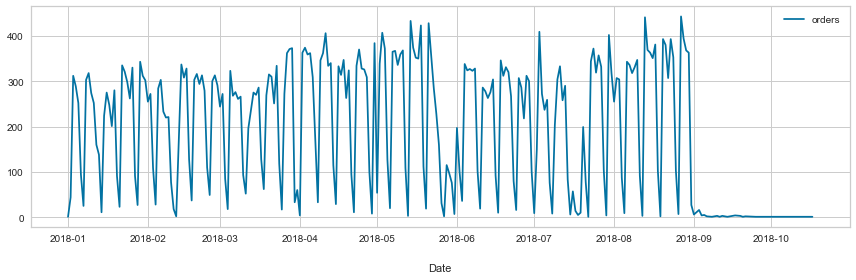

In [110]:
plot_time_serie(eda, 'order_delivered_customer_ts', s=(12, 4), time_filter=2018)

#### 1.2.3.6.4 - Month (all period)

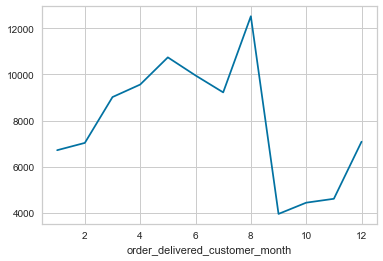

In [111]:
eda.groupby('order_delivered_customer_month')['order_delivered_customer_month'].count().plot()
plt.show()

#### 1.2.3.6.5 - Day (all period)

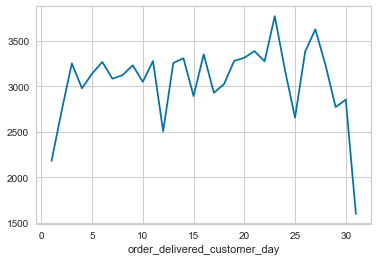

In [112]:
eda.groupby('order_delivered_customer_day')['order_delivered_customer_day'].count().plot()
plt.show()

#### 1.2.3.6.6 - Hour (all period)

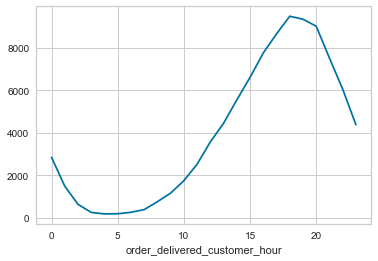

In [113]:
eda.groupby('order_delivered_customer_hour')['order_delivered_customer_hour'].count().plot()
plt.show()

#### 1.2.3.7 - Estimated delivery evaluation

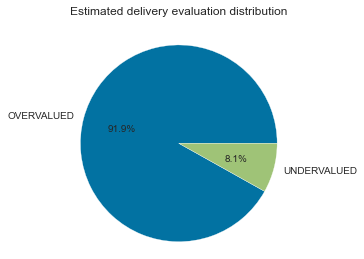

In [114]:
plot_empirical_distribution(eda['estimated_delivery_eval'],
                            var_type='quali',
                            title='Estimated delivery evaluation')

#### 1.2.3.8 - Shipping limit date reached 

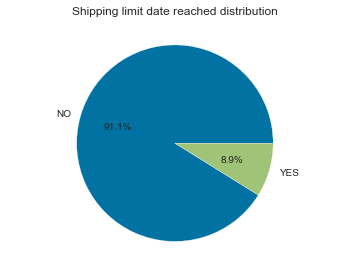

In [115]:
sldr = eda['shipping_limit_date_reached'].map(lambda v: 'Yes' if v == 1 else 'No')
plot_empirical_distribution(sldr,
                            var_type='quali',
                            title='Shipping limit date reached')

#### 1.2.3.9 - Product category name purchased

In [116]:
mrpp_label = 'product_category_name'
mrpp_gp = eda.groupby(mrpp_label)[mrpp_label].count().sort_values(ascending=False)
mrpp_gp = mrpp_gp.reset_index(name='Count')
mrpp_gp['Frequency'] = (mrpp_gp['Count'] / mrpp_gp['Count'].sum())*100
mrpp_gp[:10]

,product_category_name,Count,Frequency
0,cama_mesa_banho,9201,9.699864
1,beleza_saude,8576,9.040977
2,esporte_lazer,7481,7.886608
3,informatica_acessorios,6490,6.841878
4,moveis_decoracao,6146,6.479227
5,utilidades_domesticas,5679,5.986907
6,relogios_presentes,5470,5.766575
7,telefonia,4076,4.296994
8,automotivo,3783,3.988108
9,brinquedos,3759,3.962807


#### 1.2.4 - Most recurring product purchased

In [117]:
mrpp_label = 'most_recurring_product_purchased'
mrpp_gp = eda.groupby(mrpp_label)[mrpp_label].count().sort_values(ascending=False)
mrpp_gp = mrpp_gp.reset_index(name='Count')
mrpp_gp['Frequency'] = (mrpp_gp['Count'] / mrpp_gp['Count'].sum())*100
mrpp_gp[:5]

,most_recurring_product_purchased,Count,Frequency
0,no_recurring_product,86490,91.179354
1,cama_mesa_banho,1347,1.420032
2,esporte_lazer,779,0.821236
3,beleza_saude,777,0.819128
4,moveis_decoracao,571,0.601959


## 2 - Multivariate analysis <a class="anchor" id="fourth_2"></a>

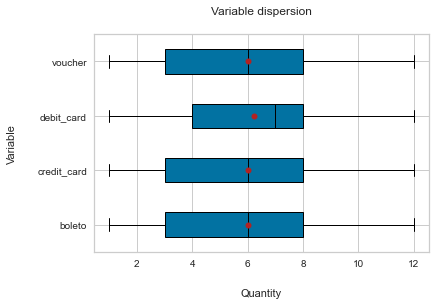

In [118]:
plot_dispersion(eda, 'payment_type', 'order_purchase_month')

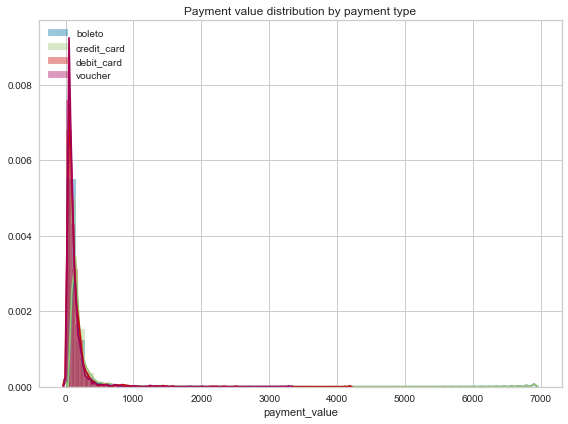

In [119]:
# Payment value distribution for each payment type (aggregated)
plot_hist_by_cat(eda, 'payment_value', 'payment_type', legend_size=10)

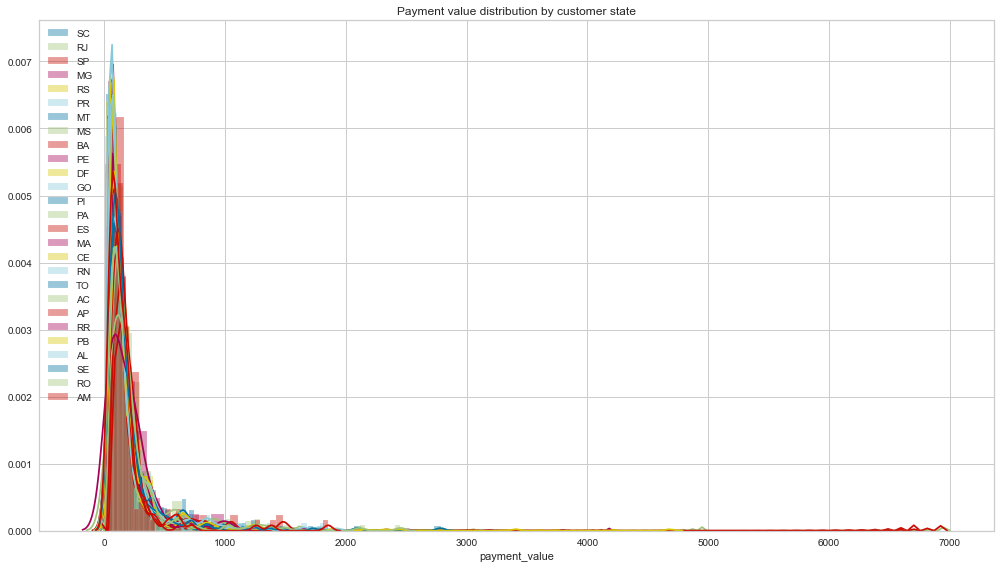

In [120]:
# Payment value distribution for each customer state (aggregated)
plot_hist_by_cat(eda, 'payment_value', 'customer_state', s=(14, 8), legend_size=10)

In [121]:
len(eda['product_category_name'].unique())

73

In [122]:
# quanti_cols = eda_filtered.select_dtypes(include=[np.number]).columns.tolist() + ['product_category_name']
quanti_cols = [col for col in eda if col in numerical_cols_excluded_geo]

quanti_eda_filtered = eda[quanti_cols + ['product_category_name']]

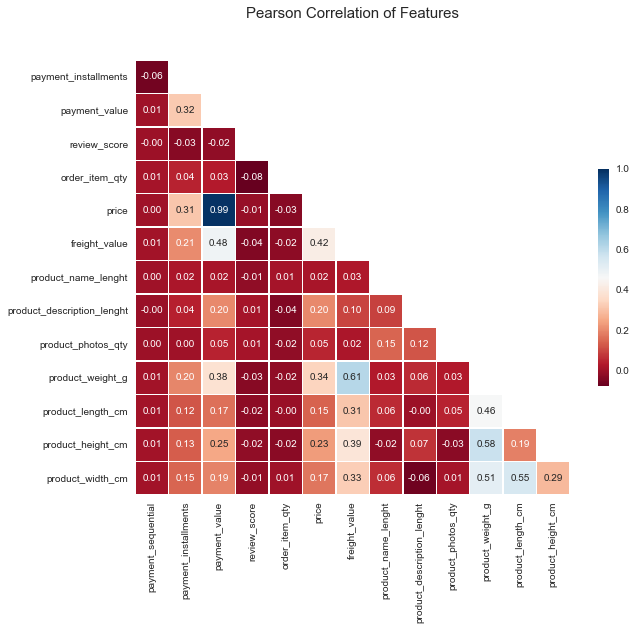

In [123]:
# Correlation matrix

quanti_df_filtered = quanti_eda_filtered.loc[:, quanti_eda_filtered.columns != 'product_category_name']

correlation_matrix(quanti_df_filtered, as_chart=True, size=(10,8))

In [124]:
# strong correlations : 
# - item price is correlated to payment value
# - item dimensions (height, length & width in cm) is correlated to item weight (in g)
# weak correlations : 
# - item weight (g) is correlated to price & payment value
# - item weight (g) is correlated to freight value

## 3 - Factorial analysis (PCA) <a class="anchor" id="fourth_3"></a>

In [125]:
# PCA by first type of property
pca_model = LinearPCA(quanti_eda_filtered, preprocess_data=True, category_label='product_category_name')
pca_model.fit()

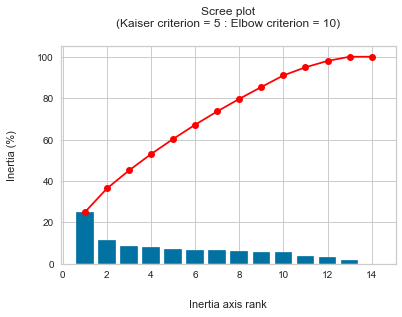

In [126]:
pca_model.scree_plot()

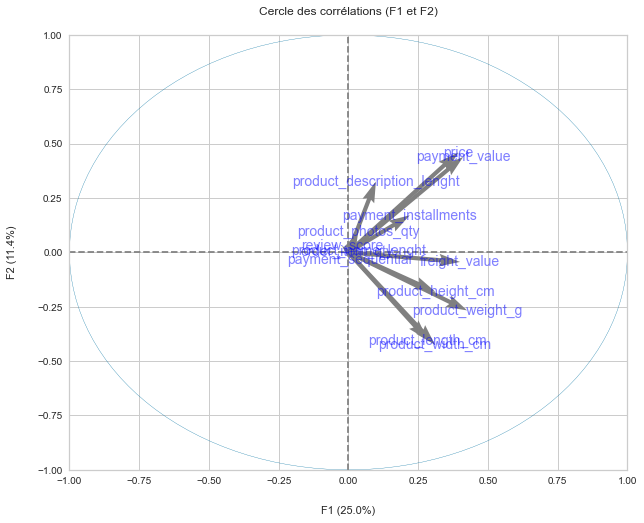

In [127]:
pca_model.plot_correlation_circle(n_plan=1, labels=pca_model.features, save_as_img=False)

In [128]:
# pca_model.plot_factorial_planes(n_plan=1,
#                                 #labels=centroids_cat,
#                                 illustrative_var=pca_model.categories)



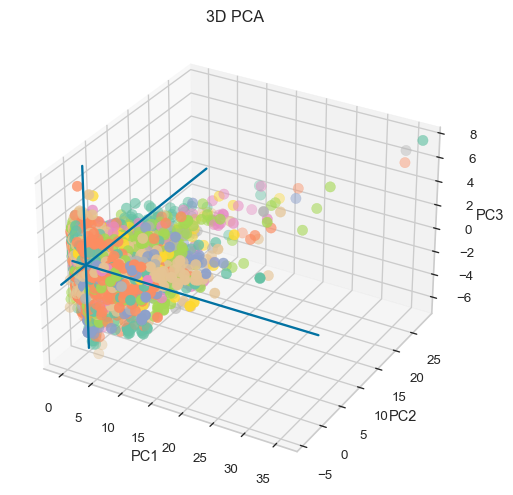

In [129]:
pca_model.plot_3d_factorial_plan()

# V - RFM segmentation <a class="anchor" id="fifth"></a>

In [130]:
eda.head(2)

,customer_id,customer_city,customer_state,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_score,geolocation_lat_customers,...,overvalued_order_delivered_cust_delay_in_days,overvalued_order_delivered_carrier_delay_from_limit_in_day,undervalued_order_delivered_cust_delay_in_days,undervalued_order_delivered_carrier_delay_from_limit_in_day,matched_order_delivered_cust_delay_in_days,matched_order_delivered_carrier_delay_from_limit_in_day,estimated_delivery_eval,shipping_limit_date_reached,product_category_name_en,order_purchase_date
98249,fd25ac83f8684107dea63fc4b864d777,sao bento do sul,SC,c08207456235b73fe23b3f65986d6856,1,boleto,1,246.84,5,-23.634558,...,15,1,1,31,1,1,overvalued,1,stationery,2018-06-28
74230,d104a1857bcb78c73dec2ac5a46ca210,bom jardim,RJ,fff2e9e3aa8644e19710216b4ef53ab2,1,boleto,1,86.15,5,-23.494059,...,13,6,1,1,1,1,overvalued,0,bed_bath_table,2017-06-06


## 1 - Preprocessing <a class="anchor" id="fifth_1"></a>

### 1.1 - Order purchase date conversion

In [131]:
eda.order_purchase_date = pd.to_datetime(eda.order_purchase_date)
recent_date = eda.order_purchase_date.max()
recent_date

Timestamp('2018-10-17 00:00:00')

### 1.2 - Build RFM subset

In [132]:
rfm_df = eda.loc[:, ['customer_id', 'order_id', 'order_purchase_date', 'payment_value']]

payment_value_reshaped = rfm_df.loc[:, 'payment_value'].values.reshape(-1, 1)

rfm_op_dict = {'order_purchase_date': lambda x: (recent_date - x.max()).days, # Recency
               'order_id': lambda x: len(x),                                  # Frequency
               'payment_value': lambda x: x.sum()}                            # Monetary 

rfm = rfm_df.groupby('customer_id').agg(rfm_op_dict)   

rfm.loc[:, 'order_purchase_date'] = rfm.loc[:, 'order_purchase_date'].astype(int)

rfm_renamed_vars = {'order_purchase_date': 'recency', 
                    'order_id': 'frequency',
                    'payment_value': 'monetary_value'}

rfm.rename(columns=rfm_renamed_vars, inplace=True)

rfm.tail()

,recency,frequency,monetary_value
customer_id,,,
fffcf5a5ff07b0908bd4e2dbc735a684,468,1,1599.14
fffea47cd6d3cc0a88bd621562a9d061,281,1,84.58
ffff371b4d645b6ecea244b27531430a,602,1,112.46
ffff5962728ec6157033ef9805bacc48,156,1,133.69
ffffd2657e2aad2907e67c3e9daecbeb,525,1,71.56


In [133]:
rfm['frequency'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 14])

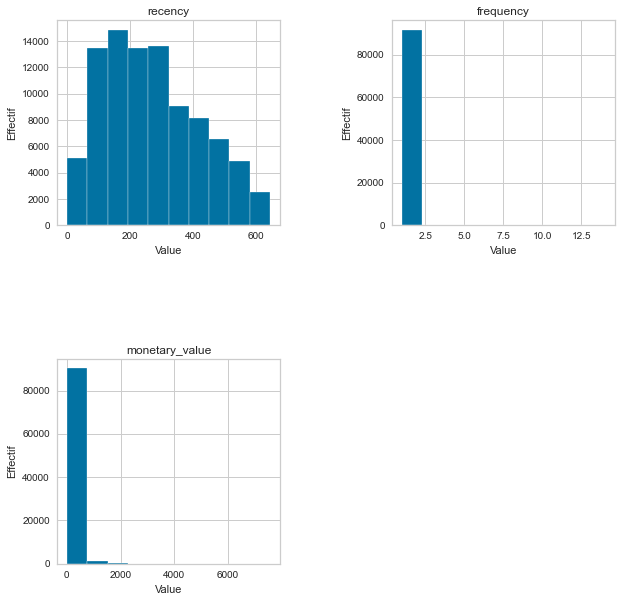

In [134]:
plot_hist_subplots(rfm, rfm.columns, (2, 2), fig_size=(10, 10))

## 2 - RFM score <a class="anchor" id="fifth_2"></a>

In [135]:
# Could use quantiles or quintiles ... 

# Quantile step : (0.1 = percentiles, 0.2 = quintiles, etc ...)
q_step = 0.25

q_range = [q for q in np.arange(q_step, 1, q_step)]

rfm_q = rfm.quantile(q=q_range).to_dict() 

## 3 - RFM Segmentation <a class="anchor" id="fifth_3"></a>

In [136]:
rfm_seg = rfm.copy()

rfm_seg['R_Quantile'] = rfm_seg['recency'].apply(RFM_score, args=('recency', rfm_q,))
rfm_seg['F_Quantile'] = rfm_seg['frequency'].apply(RFM_score, args=('frequency', rfm_q,))
rfm_seg['M_Quantile'] = rfm_seg['monetary_value'].apply(RFM_score, args=('monetary_value', rfm_q,))

rfm_seg['RFM_segment'] = rfm_seg['R_Quantile'].map(str) + rfm_seg['F_Quantile'].map(str) \
                         + rfm_seg['M_Quantile'].map(str)
rfm_seg['RFM_score'] = rfm_seg.loc[:, ['R_Quantile', 'F_Quantile', 'M_Quantile']].sum(axis=1)

In [137]:
rfm_seg.tail(2)

,recency,frequency,monetary_value,R_Quantile,F_Quantile,M_Quantile,RFM_segment,RFM_score
customer_id,,,,,,,,
ffff5962728ec6157033ef9805bacc48,156,1,133.69,3,1,3,313,7
ffffd2657e2aad2907e67c3e9daecbeb,525,1,71.56,1,1,2,112,4


In [138]:
rfm_seg.groupby('RFM_score').agg({'recency': 'mean',
                                  'frequency': 'mean',
                                  'monetary_value': ['mean', 'count'] }).round(1)

recency frequency monetary_value       
             mean      mean           mean  count
RFM_score                                        
3           488.0       1.0           41.2   5841
4           395.6       1.0           59.4  11446
5           329.8       1.0           82.0  17276
6           268.1       1.0          150.6  21783
7           200.8       1.0          181.0  16288
8           151.4       1.0          236.4  11268
9           123.1       1.1          350.9   6113
10          255.6       2.1          279.6    672
11          169.0       2.1          282.6    652
12           97.2       2.2          378.7    485

## 4 - Segment Analysis <a class="anchor" id="fifth_4"></a>

In [139]:
# The RFM scores give us (n + 1)³ theoretical segments where n is the number of quantiles used 

In [140]:
# Who are my best customers ?
# Which customers are at the verge of churning ?
# Who are lost customers that you don’t need to pay much attention to ?
# Who are your loyal customers ? 
# Which customers you must retain ?
# Who has the potential to be converted into more profitable customers ?

#### 4.1 - Best customers

In [141]:
rfm_seg[rfm_seg['RFM_segment']=='444'].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,R_Quantile,F_Quantile,M_Quantile,RFM_segment,RFM_score
customer_id,,,,,,,,
7b0eaf68a16e4808e5388c67345033c9,133,2,2340.08,4,4,4,444,12
4facc2e6fbc2bffab2fea92d2b4aa7e4,48,4,1760.75,4,4,4,444,12
87c9e7ba960e4c2e6bd786b162adc639,134,2,1653.98,4,4,4,444,12
fe81bb32c243a86b2f86fbf053fe6140,114,5,1590.76,4,4,4,444,12
fc24db02becd484accefaa5af59c18b1,111,2,1588.95,4,4,4,444,12


#### 4.2 - Customers which are at the verge of churning (customers who's recency value is low)

In [142]:
rfm_seg[rfm_seg['R_Quantile'] <= 2 ].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,R_Quantile,F_Quantile,M_Quantile,RFM_segment,RFM_score
customer_id,,,,,,,,
da122df9eeddfedc1dc1f5349a1a690c,548,2,7571.63,1,4,4,144,9
dc4802a71eae9be1dd28f5d788ceb526,593,1,6929.31,1,1,4,114,6
ff4159b92c40ebe40454e3e6a7c35ed6,499,1,6726.66,1,1,4,114,6
eebb5dda148d3893cdaf5b5ca3040ccb,528,1,4764.34,1,1,4,114,6
edf81e1f3070b9dac83ec83dacdbb9bc,531,1,4194.76,1,1,4,114,6


#### 4.3 - Lost customers

In [143]:
rfm_seg[rfm_seg['RFM_segment']=='111'].sort_values('recency', ascending=False).head()

,recency,frequency,monetary_value,R_Quantile,F_Quantile,M_Quantile,RFM_segment,RFM_score
customer_id,,,,,,,,
f7b981e8a280e455ac3cbe0d5d171bd1,644,1,19.62,1,1,1,111,3
4b3207464f5f7a48a7f63fa0b1251d86,643,1,24.42,1,1,1,111,3
fc00da40808e113053d8a26c3e854ccf,643,1,25.10,1,1,1,111,3
7122b4f327033b35961170342401066c,643,1,21.45,1,1,1,111,3
80846d571262926feb13147a5965a9ba,642,1,50.95,1,1,1,111,3


#### 4.4 - Build segments

In [144]:
# We can build a more targeted segmentation based on marketing customer classification
# (10 unique segments created)

# q = 0.25 (main segmentation)
segt_map = {r'11': 'Churned customers',
            r'1[2-3]': 'Former potential loyalists',
            r'[1-2]4': 'Former best customers',
            r'21': 'About to churn',
            r'22': 'Average customers',
            r'[2-3][3-4]': 'Loyal customers',
            r'31': 'Rising customers',
            r'41': 'New customers',
            r'[3-4][1-2]': 'Potential loyalists',
            r'4[3-4]': 'Best customers'}

# q = 0.2 

# segt_map = {r'[1-2][1-2]': 'Churned customers',
#             r'[1-2][3-4]': 'Former potential loyalists',
#             r'[1-2]5': 'Former best customers',
#             r'3[1-2]': 'About to churn',
#             r'33': 'Average customers',
#             r'[3-4][4-5]': 'Loyal customers',
#             r'41': 'Rising customers',
#             r'51': 'New customers',
#             r'[4-5][2-3]': 'Potential loyalists',
#             r'5[4-5]': 'Best customers'}

# Old segmentations 

# segt_map = {r'[4-5][4-5][1-5]': 'Best Customers',
#             r'[1-4][4-5][1-4]': 'Loyal Customers',
#             r'[1-5][1-5][4-5]': 'Big Spenders',
#             r'[3][1-3][1-3]': 'Average Customers',
#             r'[4-5]1[1-5]': 'New Customers',
#             r'[1-2][1-4][4-5]': 'Almost Lost',
#             r'[1-2][4-5][4-5]': 'Lost Customers',
#             r'[1-2][1-2][1-3]': 'Lost Cheap Customers'
#             }

# def segment_customers(rfm_score):
#     if rfm_score >= 12:
#         return 'Gold'
#     elif (rfm_score >= 8) and (rfm_score < 12):
#         return 'Silver'
#     else:
#         return 'Bronze'


rfm_seg['segment'] = rfm_seg['R_Quantile'].map(str) + rfm_seg['F_Quantile'].map(str) \
                     # + rfm_seg['M_Quantile'].map(str)
rfm_seg['segment'] = rfm_seg['segment'].replace(segt_map, regex=True)
# rfm_seg['segment'] = rfm_seg['RFM_score'].map(lambda x: segment_customers(x))

In [145]:
rfm_seg['segment'].unique().tolist()

['Rising customers',
 'Churned customers',
 'About to churn',
 'New customers',
 'Former best customers',
 'Best customers',
 'Loyal customers']

In [146]:
rfm_seg.groupby('segment')['monetary_value'].count().to_frame(name='Count')

,Count
segment,
About to churn,22282
Best customers,757
Churned customers,22339
Former best customers,1232
Loyal customers,739
New customers,22233
Rising customers,22242


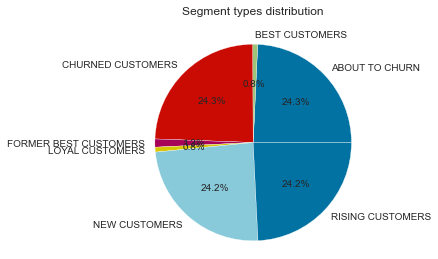

In [147]:
plot_empirical_distribution(rfm_seg['segment'], var_type='quali', title='Segment types')
# 7 out of 10 unique segments are represented here

In [148]:
# It seems that around 49% of customers are close to be lost (or already lost) ...

#### 4.5 - Recency analysis

In [149]:
# Recency in months 
recency_mo = [str(int(x//30))+' months' for x in list(rfm_q['recency'].values())]
recency_mo

['5 months', '8 months', '12 months']

<AxesSubplot:>

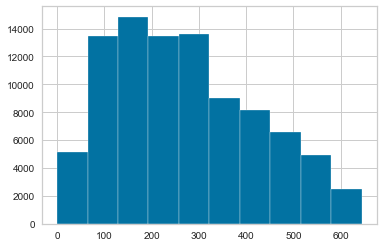

In [150]:
rfm_seg['recency'].hist()

In [151]:
measures_table(rfm_seg, 'recency').T

,count,mean,std,min,25%,50%,75%,max
recency,91824.0,271.988554,150.234654,0.0,152.0,252.0,380.0,644.0


#### 4.6 - Frequency analysis

<AxesSubplot:>

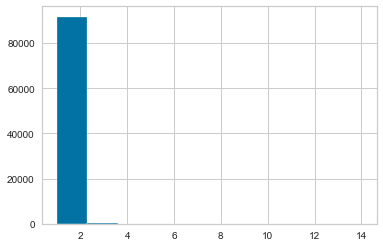

In [152]:
rfm_seg['frequency'].hist()

In [153]:
measures_table(rfm_seg, 'frequency').T

,count,mean,std,min,25%,50%,75%,max
frequency,91824.0,1.033031,0.206745,1.0,1.0,1.0,1.0,14.0


#### 4.7 - Monetary value analysis

<AxesSubplot:>

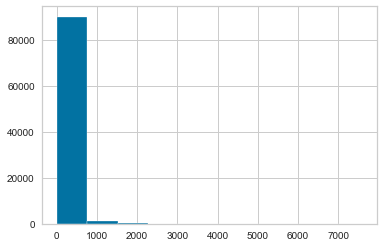

In [154]:
rfm_seg['monetary_value'].hist()

In [155]:
measures_table(rfm_seg, 'monetary_value').T

,count,mean,std,min,25%,50%,75%,max
monetary_value,91824.0,151.723315,203.953628,9.09,58.71,99.45,168.6225,7571.63


#### 4.8 - Frequency & monetary value analysis

In [156]:
all_freq_dist = rfm_seg.groupby('frequency')['monetary_value'].mean().round(1).to_frame().T
all_freq_dist

frequency,1,2,3,4,5,6,7,9,14
monetary_value,148.1,258.0,369.0,583.1,689.5,537.5,821.8,959.8,797.4


,count,mean,std,min,25%,50%,75%,max
monetary_value,89096.0,148.061967,200.345469,9.09,57.86,97.205,164.79,6929.31


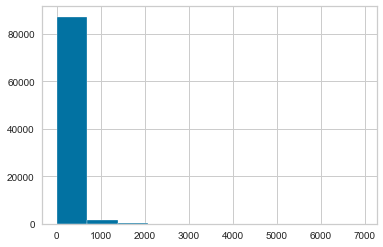

In [157]:
unique_frequency_df = rfm_seg[rfm_seg.frequency == 1]
unique_frequency_df['monetary_value'].hist()
measures_table(unique_frequency_df, 'monetary_value').T

,count,mean,std,min,25%,50%,75%,max
monetary_value,2728.0,271.302295,273.002311,29.91,136.4075,202.84,321.615,7571.63


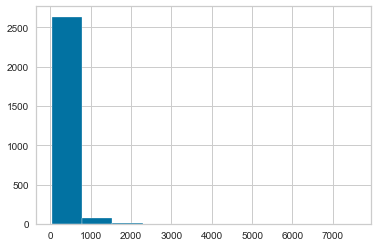

In [158]:
multi_frequency_df = rfm_seg[rfm_seg.frequency > 1]
multi_frequency_df['monetary_value'].hist()
measures_table(multi_frequency_df, 'monetary_value').T

# VI - Build modelization subset <a class="anchor" id="sixth"></a>

### 1 - Feature overview per dataset <a class="anchor" id="sixth_1"></a>

#### 1.1 - Original merged dataset

In [159]:
# Get original dataframe specific columns
df_specific_columns = [col for col in df.columns.tolist() if col not in eda.columns]

# Display original dataframe specific columns
df_specific_columns

['order_status', 'review_id', 'seller_id', 'product_id']

#### 1.2 - EDA dataset

In [160]:
# Get EDA dataframe specific columns
eda_specific_columns = [col for col in eda.columns.tolist() if col not in df.columns]

# Display EDA dataframe specific columns
eda_specific_columns

['product_category_name_en', 'order_purchase_date']

### 2 - Feature engineering <a class="anchor" id="sixth_2"></a>

#### 2.1 - Review recency feature

In [161]:
# Convert review creation timestamp to date
df['review_creation_date'] = pd.to_datetime(df['review_creation_ts'], unit='s')

# Date of last review 
last_review_date = df['review_creation_date'].max()

# Recency from last review in days
review_recency_agg = {'review_creation_date': lambda x: (last_review_date - x.max()).days}

# Recency from last review aggregated by customer id
review_recency_per_customer = df.groupby('customer_id').agg(review_recency_agg)

# Rename review creation date feature as review recency
review_recency_per_customer.rename(columns={'review_creation_date': 'review_recency'}, inplace=True)

# Transform review recency data as dictionary with customer_id as keys
review_recency_per_customer_dict = dict(review_recency_per_customer['review_recency'])

# Map review recency data to customer_id feature
eda.loc[:, 'review_recency'] = eda.loc[:, 'customer_id'].map(review_recency_per_customer_dict)

#### 2.2 - Average quantitative features

In [162]:
# eda['total_payment_sequential'].describe()

In [163]:
# Select required quantitative features 
average_quanti_features = ['price',
                           'freight_value',
                           'payment_value',
                           'order_item_qty',
                           'total_payment_sequential',
                           'review_score']

# Get median value for each selected quantitative features
for feature in average_quanti_features:
    # Compute the median of the feature
    average_feature = eda.groupby(['customer_id'])[feature].mean()#.median()
    # Map average feature to EDA subset
    eda.loc[:, f'average_{feature}'] = eda.loc[:, 'customer_id'].map(dict(average_feature))
    
# Build list of average features
average_features = [col for col in eda.columns if col.startswith('average')]

#### 2.3 - Main order purchase hour

In [164]:
period = ['month', 'day']
for p in period:
    main_order_purchase_p = eda.groupby(['customer_id'])[f'order_purchase_{p}'].agg(lambda x: 
                                                                                    pd.Series.mode(x)[0])
    eda.loc[:, f'main_order_purchase_{p}'] = eda.loc[:, 'customer_id'].map(dict(main_order_purchase_p))

#### 2.4 - RFM features

In [165]:
# Get main RFM variables as training features
# (RFM score & segments variables will be used as targets => compare clustering results with RFM segmentation)

# Build list of RFM features
rfm_features = ['recency', 'frequency', 'monetary_value', 'RFM_score', 'segment']

# Join RFM features to EDA subset
eda = eda.join(rfm_seg.loc[:, rfm_features], on='customer_id')

In [166]:
measures_table(eda, 'frequency').T

,count,mean,std,min,25%,50%,75%,max
frequency,94857.0,1.074407,0.36288,1.0,1.0,1.0,1.0,14.0


### 3 - Cohort analysis <a class="anchor" id="sixth_3"></a>

#### 3.1 - Evaluate customer retention

In [167]:
# Check multiple frequency (many orders) by analysing frequency by order purchase date

# Full length dataframe
pd.set_option('display.max_colwidth', None)

# Convert order purchase timestamp to datetime
eda.loc[:, 'order_purchase_datetime'] = pd.to_datetime(eda.order_purchase_ts, unit='s')

# Aggregate multi-orders frequency by customer_id
freq_gp = eda[eda['frequency'] > 1].groupby(['customer_id'])['order_purchase_datetime']

# Get list of order dates for each customer
freq_gp = freq_gp.apply(list).reset_index(name='datetime')

# Convert datetime as date
freq_gp['date'] = freq_gp['datetime'].map(lambda l: [x.date() for x in l])

# Convert datetime as hour
freq_gp['time'] = freq_gp['datetime'].map(lambda l: [x.time() for x in l])

# Get date count for each customer
freq_gp['date_count'] = freq_gp['date'].map(len)

# Get unique date count for each customer
freq_gp['unique_date_count'] = freq_gp['date'].map(set).map(len)

freq_gp.head()

,customer_id,datetime,date,time,date_count,unique_date_count
0,004288347e5e88a27ded2bb23747066c,"[2018-01-14 07:36:54, 2017-07-27 14:13:03]","[2018-01-14, 2017-07-27]","[07:36:54, 14:13:03]",2,2
1,00a39521eb40f7012db50455bf083460,"[2018-06-03 10:12:57, 2018-05-23 20:14:21]","[2018-06-03, 2018-05-23]","[10:12:57, 20:14:21]",2,2
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,"[2017-03-21 19:25:23, 2017-03-21 19:25:22]","[2017-03-21, 2017-03-21]","[19:25:23, 19:25:22]",2,1
3,011575986092c30523ecb71ff10cb473,"[2018-02-17 15:54:49, 2018-04-18 21:58:08]","[2018-02-17, 2018-04-18]","[15:54:49, 21:58:08]",2,2
4,011b4adcd54683b480c4d841250a987f,"[2017-08-22 12:51:29, 2018-02-15 11:40:57]","[2017-08-22, 2018-02-15]","[12:51:29, 11:40:57]",2,2


In [168]:
measures_table(freq_gp, 'unique_date_count').T.astype(int)

,count,mean,std,min,25%,50%,75%,max
unique_date_count,2728,1,0,1,1,2,2,14


#### 3.2 - Build cohort data

In [169]:
# Select cohort features from EDA dataset
cohort_cols = ['customer_id', 'order_id', 'order_purchase_date']

# Build cohort data from EDA dataset
cohort_data, cohort_size = build_retention_matrix(eda, cohort_cols)
# Normalize retention in percentage
cohort_data * 100

period_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Cohort,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,1.149425,0.383142,NaN,0.383142,0.383142,0.383142,0.383142,NaN,NaN,0.383142,0.766284,1.149425,NaN,0.383142,NaN,NaN,0.766284,NaN,0.383142
2017-02,100.0,0.625000,0.234375,0.312500,0.234375,0.156250,0.156250,0.234375,0.078125,0.078125,0.156250,0.312500,0.234375,0.156250,0.078125,0.156250,0.234375,NaN,0.078125,NaN
2017-03,100.0,0.524246,0.305810,0.393185,0.305810,0.087374,0.262123,0.262123,0.262123,0.218436,0.218436,0.043687,0.043687,0.305810,0.131062,0.174749,0.131062,0.087374,NaN,NaN
2017-04,100.0,0.793651,0.283447,0.226757,0.283447,0.170068,0.283447,0.056689,0.396825,0.226757,0.283447,0.113379,NaN,0.113379,0.113379,0.170068,0.170068,NaN,NaN,NaN
2017-05,100.0,0.696185,0.306321,0.167084,0.362016,0.389864,0.222779,0.334169,0.222779,0.194932,0.250627,0.306321,0.139237,0.167084,0.167084,0.222779,NaN,NaN,NaN,NaN
2017-06,100.0,0.718719,0.555374,0.457367,0.359360,0.261352,0.359360,0.196014,0.196014,0.196014,0.130676,0.196014,0.163345,0.228683,0.261352,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.633867,0.150921,0.422578,0.271657,0.271657,0.392394,0.271657,0.211289,0.271657,0.332025,0.452762,0.090552,0.332025,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.679777,0.461277,0.194222,0.291333,0.534110,0.242777,0.218500,0.194222,0.169944,0.242777,0.121389,0.145666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,1.061289,0.291855,0.424516,0.424516,0.291855,0.238790,0.318387,0.212258,0.265322,0.185726,0.212258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.3 - Plot cohort monthly retention rate

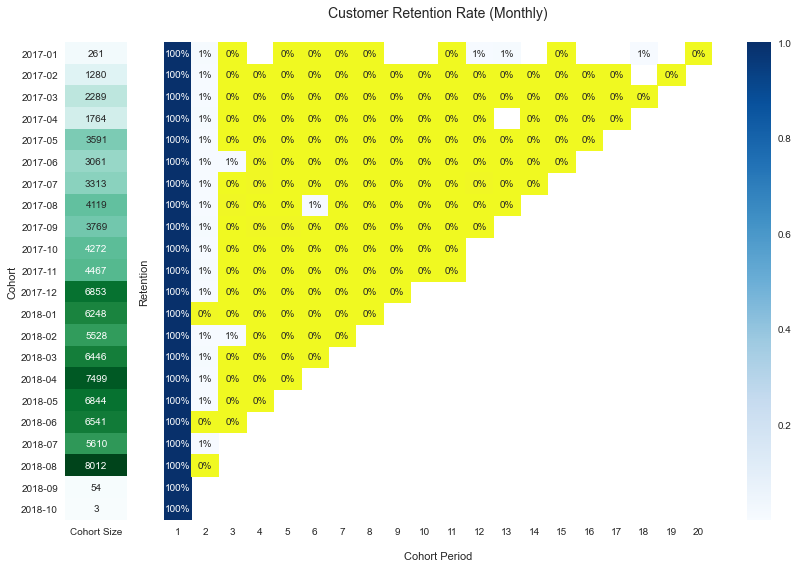

In [170]:
# Cohort analysis heatmap

# Plot retention matrix from cohort data
plot_cohort_analysis(cohort_data, cohort_size, threshold=.005)

In [171]:
# (Optional retention plot)
# retention_matrix.T.plot(figsize=(10,5))
# plt.title('Cohorts: User Retention')
# plt.xticks(np.arange(1, 12.1, 1))
# plt.xlim(1, 12)
# plt.ylabel('% of Cohort Purchasing')

### 4 - Modelization dataset <a class="anchor" id="sixth_4"></a>

#### 4.1 - Feature selection

In [172]:
# selected variables 

model_features = ['customer_id',
                  # Variable required to implement the segmentation update
                  'order_purchase_date',
                  # Feature engineering variables
                  'customer_total_products_purchased',
                  #'cust_uniq_products_purchased_ratio',
                  'customer_recurring_products_purchased_ct',
                  #'customer_recurring_products_purchased_ratio',
                  'customer_uniq_sellers_ct',
                  'customer_total_sellers_ct',
                  #'customer_uniq_sellers_ratio',
                  'customer_total_recurring_sellers_ct',
                  #'customer_recurring_sellers_ratio',
                  'customer_loyalty_indicator',
                  'customer_dist_km',
                  # Added variables
                  'review_recency',
                  'main_order_purchase_month',
                  'main_order_purchase_day',
                  'customer_state'
                  ] + average_features + rfm_features # average & RFM features

# Apply feature selection to working dataset
df_model_subset = eda.loc[:, model_features].copy()

# Get unique customers
df_model_subset.drop_duplicates('customer_id', inplace=True)

# print(df_model_subset.shape)

# Filter constant columns
df_model_subset = df_model_subset.loc[:, (df_model_subset != df_model_subset.iloc[0]).any()]

# print(df_model_subset.shape)

# Select quantitative features
quanti_cols = df_model_subset.select_dtypes(include=[np.number]).columns

#### 4.2 - Distribution overview

#### Histogram

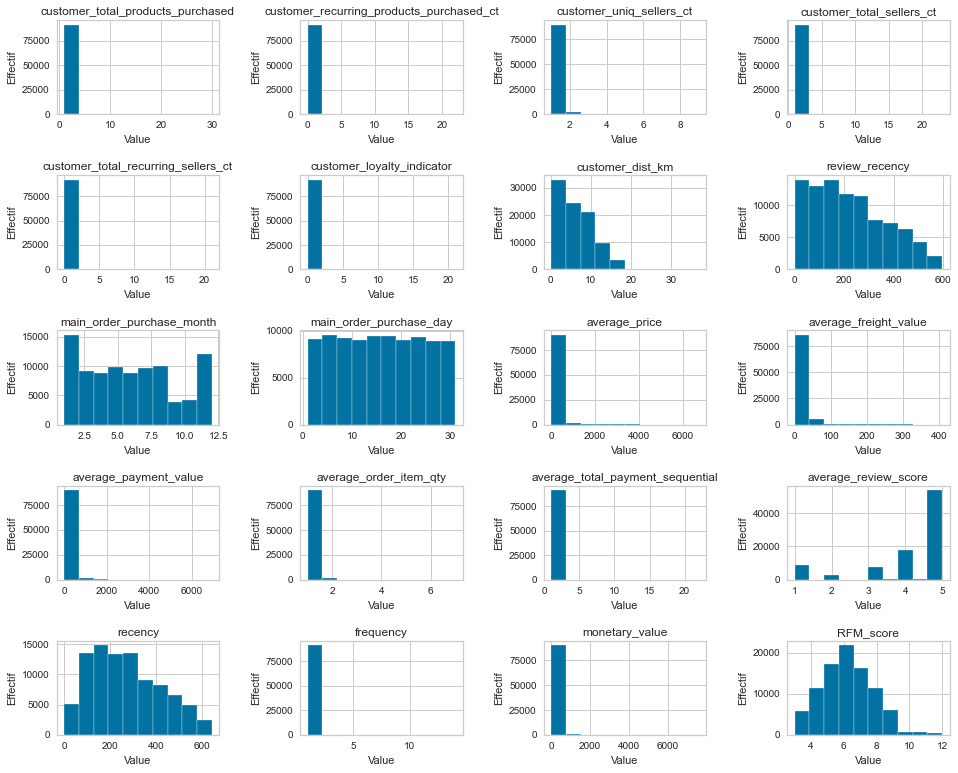

In [173]:
plot_hist_subplots(df_model_subset, quanti_cols, (6, 4), fig_size=(16, 16))

#### Normal probability plot

In [174]:
# Filter null values

df_model_rows_ct = df_model_subset.shape[0]

for col in quanti_cols:
    #print(col, df_model_subset.shape)
    # Trick in order to see probplot with these columns (coerce non-zero values)
    if 'recurring' in col or 'loyalty' in col:
        df_model_subset[col] = df_model_subset[col] + 1
    df_model_subset = df_model_subset[df_model_subset[col] > 0]

filtered_df_model_rows_ct = df_model_subset.shape[0]

get_data_loss(filtered_df_model_rows_ct, df_model_rows_ct)

Dataframe rows reduced by 0.8 % (91824 -> 91129)


In [175]:
# measures_table(df_model_subset, 'customer_recurring_products_purchased_ct')

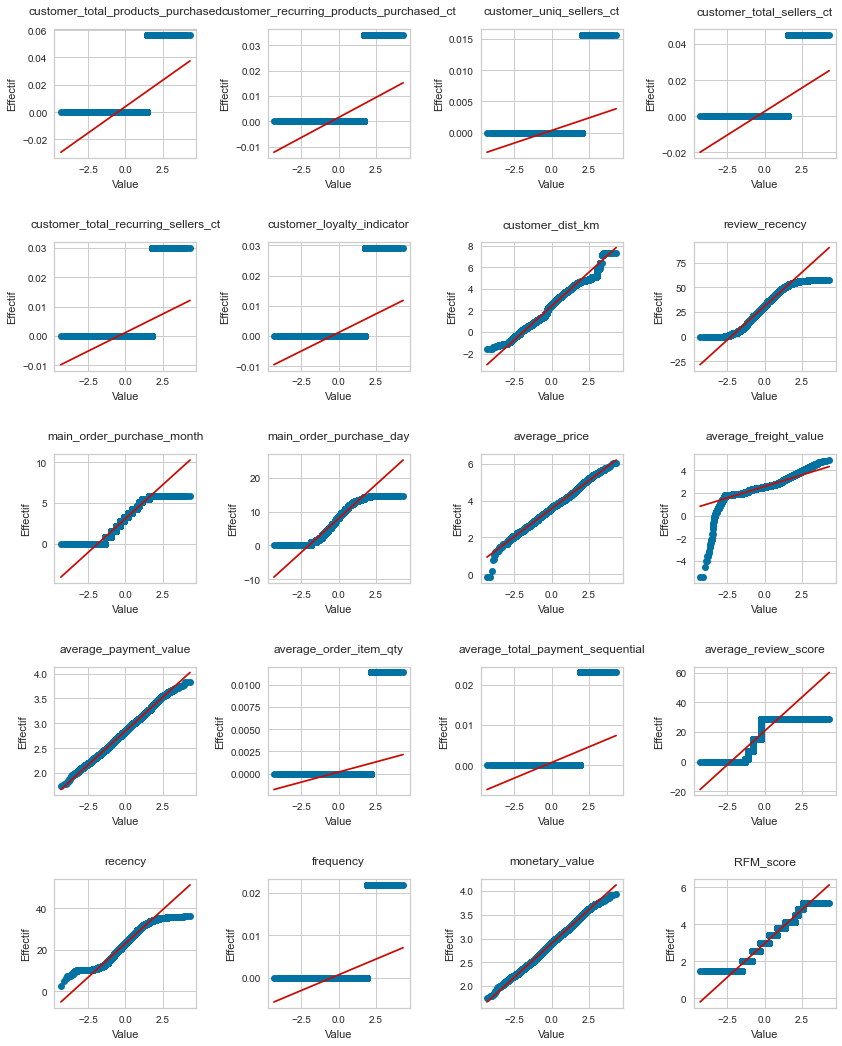

In [176]:
plot_norm_subplots(df_model_subset, quanti_cols, (5, 4))

In [177]:
# Undo normalizing recurring and loyalty labeled columns
recurring_and_loyalty_cols = [col for col in quanti_cols if 'recurring' in col or 'loyalty' in col]
for col in recurring_and_loyalty_cols:
    df_model_subset[col] = df_model_subset[col] - 1

#### 4.3 - Normalize frequency distribution 

In [178]:
# Get frequency count by unique customers
frequency_count(df_model_subset, col='customer_id')

frequency,1,2,3,4,5,6,7,9,14
count,88415.000,2497.00,172.000,28.000,9.00,3.000,3.000,1.000,1.000
%,97.022,2.74,0.189,0.031,0.01,0.003,0.003,0.001,0.001


In [179]:
# Estimate multiple orders money supply proportion
money_supply_unique_freq = df_model_subset[df_model_subset['frequency'] == 1]['monetary_value'].sum()
money_supply_multi_freq = df_model_subset[df_model_subset['frequency'] > 1]['monetary_value'].sum()
money_supply = money_supply_unique_freq + money_supply_multi_freq
money_supply_ratio = round((money_supply_multi_freq / money_supply)*100, 1)
f'Multiple orders represent around {money_supply_ratio}% of Olist money supply'

'Multiple orders represent around 5.3% of Olist money supply'

In [180]:
# Create backup with original unbalanced frequency
df_model_subset_backup = df_model_subset.copy()
# Create a copy which excludes the frequency feature
df_exclude_freq = df_model_subset.iloc[:, df_model_subset.columns != 'frequency'].copy()
# Normalize frequency distribution 
df_model_subset = normalize_frequency(df_model_subset, sampling_frac=(0.0245, 0.7, 0.7)) # (0.008, 0.25, 0.25)
df_model_subset.shape 

Once orders sample size : 2166
Twice orders sample size : 1748


(4066, 24)

,count,mean,std,min,25%,50%,75%,max
frequency,4066.0,1.522135,0.667006,1.0,1.0,1.0,2.0,14.0


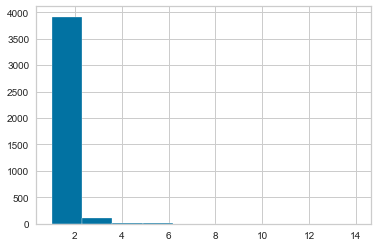

In [181]:
df_model_subset.frequency.hist()
measures_table(df_model_subset, 'frequency').T

In [182]:
frequency_count(df_model_subset, col='customer_id')

frequency,1,2,3,4,5,6,7,9,14
count,2166.000,1748.000,118.000,18.000,9.000,2.000,3.000,1.000,1.000
%,53.271,42.991,2.902,0.443,0.221,0.049,0.074,0.025,0.025


In [183]:
df_model_subset.describe()

,customer_total_products_purchased,customer_recurring_products_purchased_ct,customer_uniq_sellers_ct,customer_total_sellers_ct,customer_total_recurring_sellers_ct,customer_loyalty_indicator,customer_dist_km,review_recency,main_order_purchase_month,main_order_purchase_day,average_price,average_freight_value,average_payment_value,average_order_item_qty,average_total_payment_sequential,average_review_score,recency,frequency,monetary_value,RFM_score
count,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000
mean,1.639941,0.325381,1.366945,1.596409,0.229464,0.197900,6.513070,214.808411,5.485489,13.924742,116.388456,19.737413,137.660415,1.021340,1.047959,4.170904,262.077226,1.522135,202.956874,7.908756
std,1.031946,0.762355,0.573399,0.887900,0.683834,0.509139,4.007398,143.376642,3.179100,8.634736,162.489370,13.647116,168.831433,0.135831,0.315896,1.188287,143.474043,0.667006,226.988342,2.543358
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.177729,1.000000,1.000000,1.000000,4.200000,1.335000,12.890000,1.000000,1.000000,1.000000,34.000000,1.000000,12.890000,3.000000
25%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.996663,100.000000,3.000000,6.000000,45.056250,13.471250,62.397500,1.000000,1.000000,4.000000,147.000000,1.000000,79.502500,6.000000
50%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,6.140259,192.000000,5.000000,13.000000,78.990000,16.622500,97.527500,1.000000,1.000000,5.000000,239.000000,1.000000,143.615000,8.000000
75%,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000,9.152582,314.000000,8.000000,21.000000,132.406250,21.150000,158.116250,1.000000,1.000000,5.000000,362.000000,2.000000,241.562500,10.000000
max,30.000000,22.000000,9.000000,23.000000,21.000000,10.500000,35.120385,590.000000,12.000000,31.000000,4059.000000,248.540000,4163.510000,3.500000,11.000000,5.000000,638.000000,14.000000,4163.510000,12.000000


In [184]:
# Get features with over-represented null values
over_repr_null_values_cols = [col for col in recurring_and_loyalty_cols if df_model_subset[col].median() == 0]
# Filter feature with over-represented null values (necessary for log scaling and probability plot)
quanti_cols_filtered = [col for col in quanti_cols if col not in over_repr_null_values_cols]
# Display list of features with over-represented null values
over_repr_null_values_cols

['customer_recurring_products_purchased_ct',
 'customer_total_recurring_sellers_ct',
 'customer_loyalty_indicator']

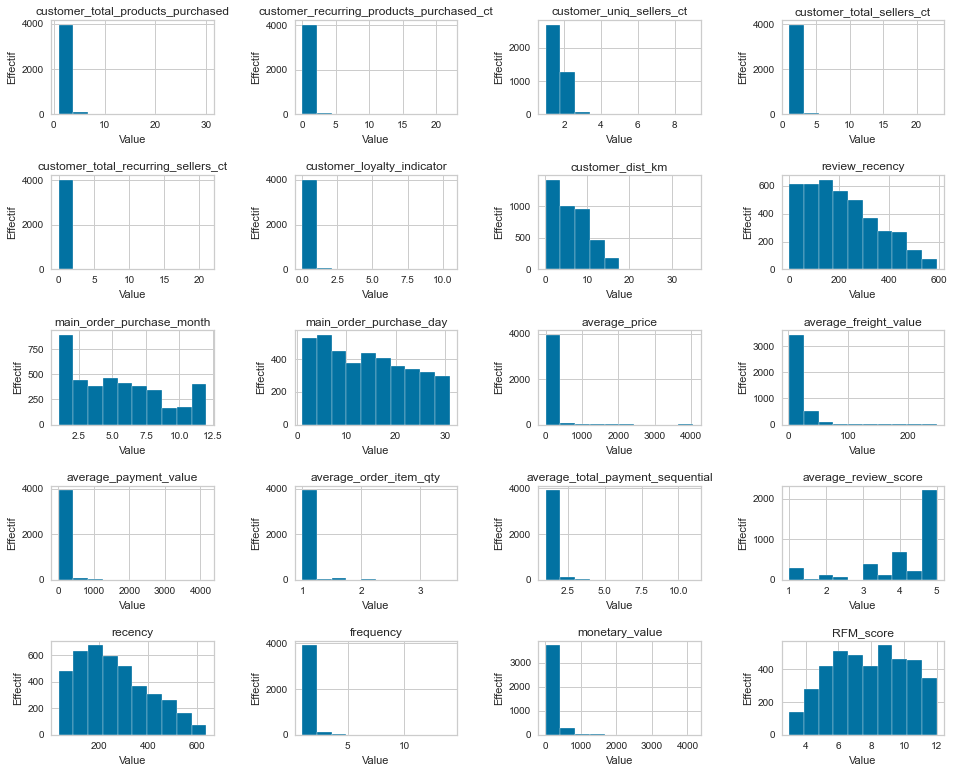

In [185]:
plot_hist_subplots(df_model_subset, quanti_cols, (6, 4), fig_size=(16, 16))

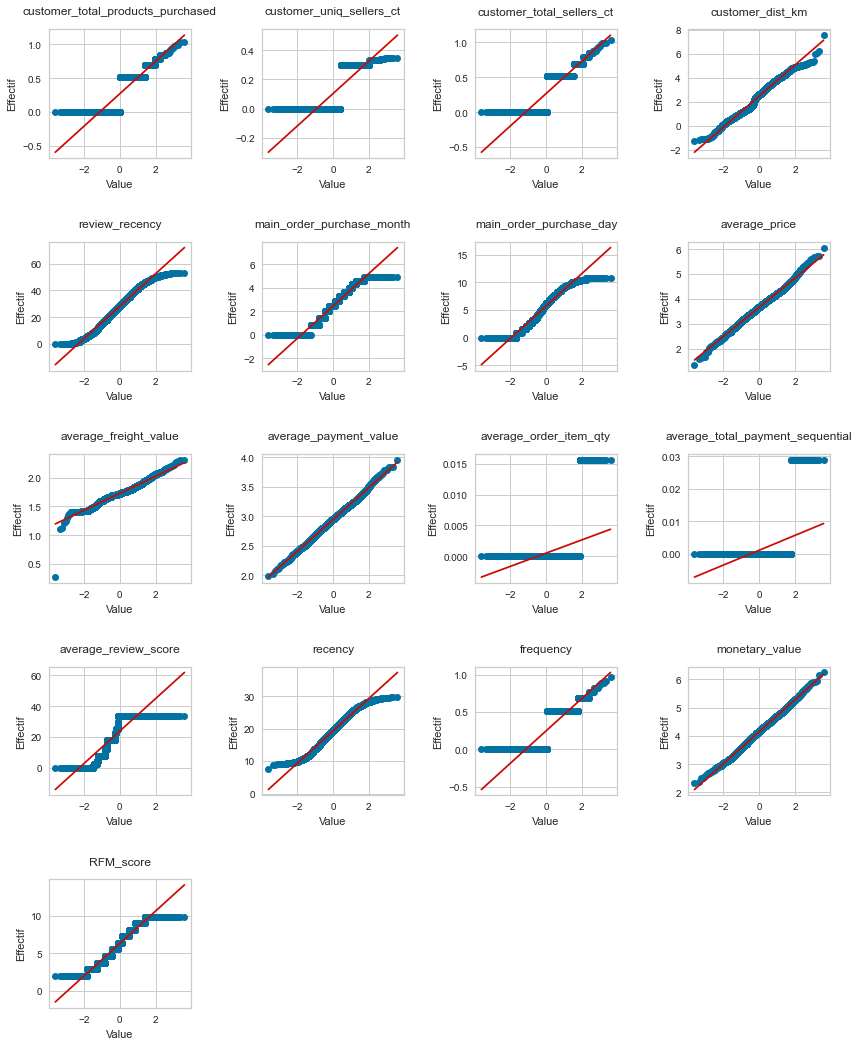

In [186]:
plot_norm_subplots(df_model_subset, quanti_cols_filtered, (5, 4))

#### 4.4 - Feature scaling  (log scaling)

In [187]:
# Create a log scaling subset 
df_model_subset_scaled = df_model_subset.copy()

# Delete features with over-represented null values
delete_cols(df_model_subset_scaled, over_repr_null_values_cols)

# (optional) Delete features with over-represented null values to no frequency subset
delete_cols(df_exclude_freq, over_repr_null_values_cols)

# Update of the list of quantitative variables
quanti_cols_ls = quanti_cols_filtered

# Apply log scaling to subset
df_model_subset_scaled = log_scaling(df_model_subset_scaled,
                                     quanti_cols_ls,
                                     pickle_path='../data/pkl')

# (Optional) apply log scaling to no frequency subset
df_exclude_freq_scaled = log_scaling(df_exclude_freq,
                                     [col for col in quanti_cols_ls if col != 'frequency'],
                                     pickle_path='../data/pkl')

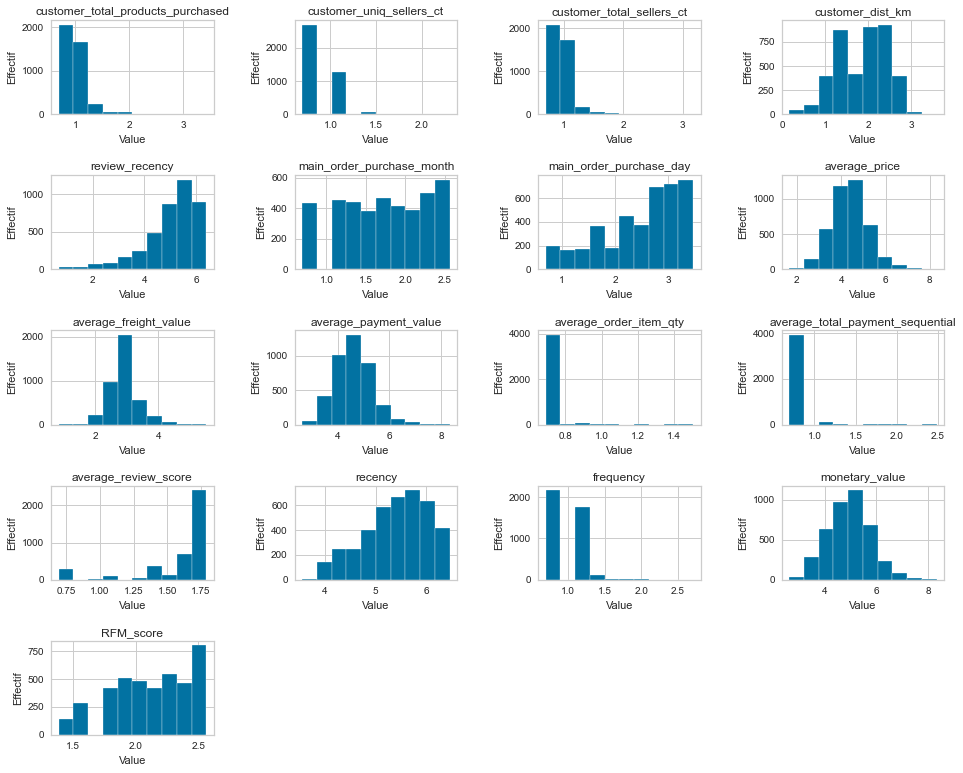

In [188]:
plot_hist_subplots(df_model_subset_scaled, quanti_cols_ls, (6, 4), fig_size=(16, 16))

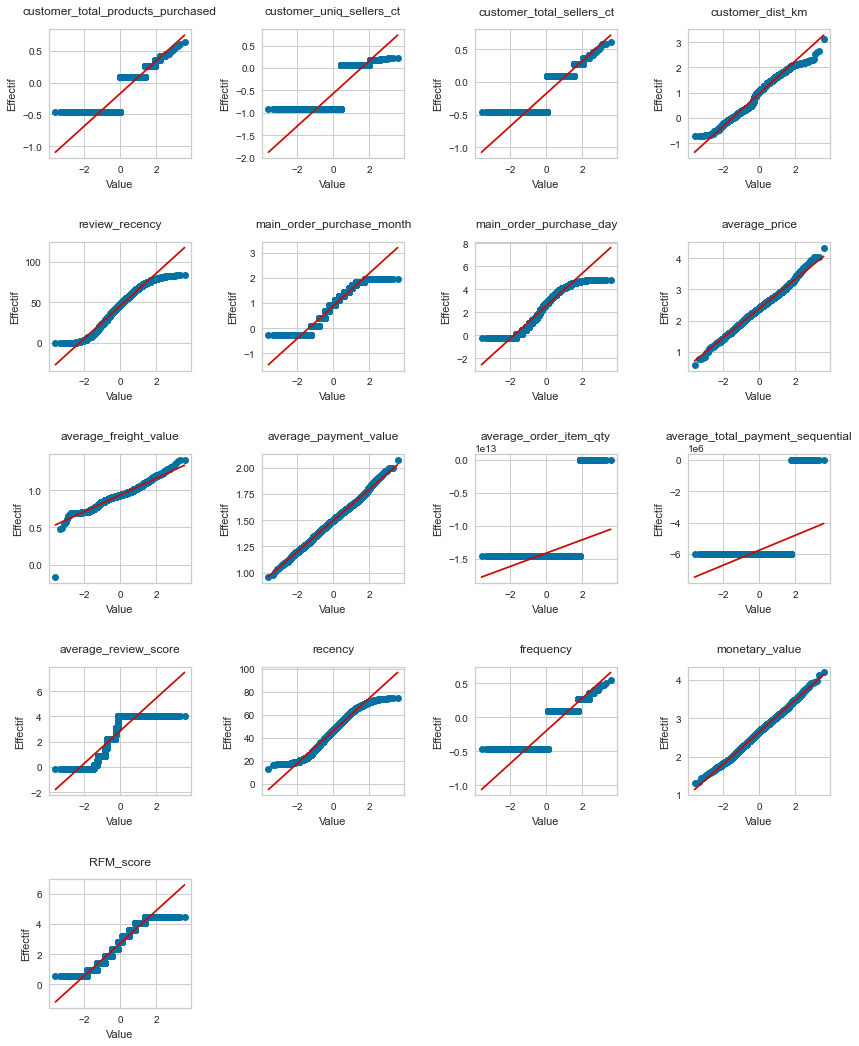

In [189]:
plot_norm_subplots(df_model_subset_scaled, quanti_cols_ls, (5, 4))

#### 4.5 - Export scaled data  

In [190]:
# Feature naming patterns
model_features_renamed = {'customer_total_products_purchased': 'total_products_purchased',
                          #'cust_uniq_products_purchased_ratio': 'unique_products_purchased_ratio',
                          'customer_recurring_products_purchased_ct': 'total_recurring_products_purchased',
                          #'customer_recurring_products_purchased_ratio': 'recurring_products_purchased_ratio',
                          'customer_uniq_sellers_ct': 'total_unique_sellers',
                          'customer_total_sellers_ct': 'total_sellers',
                          #'customer_uniq_sellers_ratio': 'unique_sellers_ratio',
                          'customer_total_recurring_sellers_ct': 'total_recurring_sellers',
                          #'customer_recurring_sellers_ratio': 'recurring_sellers_ratio',
                          'customer_loyalty_indicator': 'loyalty_indicator',
                          'customer_dist_km': 'distance_to_sao_paulo'}

# List of invalid features to delete
invalid_features = ['total_unique_sellers',
                    #'total_sellers', # 
                    #'total_products_purchased', #
                    #'total_recurring_products_purchased',
                    'customer_state',
                    'distance_to_sao_paulo',
                    'average_order_item_qty',
                    'average_total_payment_sequential',
                    'average_review_score', #
                    'review_recency', #
                    #'recency',
                    #'frequency',
                    'RFM_score'
                    ]

# Rename features
df_model_subset_scaled.rename(columns=model_features_renamed, inplace=True)
df_model_subset_backup.rename(columns=model_features_renamed, inplace=True)
# (Optional)
df_exclude_freq_scaled.rename(columns=model_features_renamed, inplace=True)
# Remove invalid features
df_model_subset_scaled = df_model_subset_scaled.loc[:, ~df_model_subset_scaled.columns.isin(invalid_features)]
# (Optional)
df_exclude_freq_scaled = df_exclude_freq_scaled.loc[:, ~df_exclude_freq_scaled.columns.isin(invalid_features)]
# Export data to modelization
df_model_subset_scaled.to_csv(f'../data/csv/olist_train_data.csv', index=False)
# (Optional)
df_exclude_freq_scaled.to_csv(f'../data/csv/olist_train_data_no_freq_version.csv', index=False)
# Export merged original dataset as segmentation evaluator
df_model_subset_features = [col for col in df_model_subset_backup.columns if col not in eda.columns]
eda = eda.merge(df_model_subset_backup[df_model_subset_features+['customer_id']], on='customer_id')
eda.to_csv('../data/csv/olist_validation_set.csv', index=False)